In [1]:
# Import the Libraries
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from torch.utils.data import random_split

# Define the dataset and transformations
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=tensor_transform)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=50,
                                         shuffle=False)
# Test dataset and loader remain the same
test_dataset = datasets.MNIST(root="./data",
                               train=False,
                               download=True,
                               transform=tensor_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=50,
                                          shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 115275147.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40084610.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34161659.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10220240.76it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(len(val_dataset))
print(len(test_dataset))
print(len(train_dataset))

12000
10000
48000


28* italicised text28=784 ->256-> 128 -> 64 -> 32 ->16 -> 8 -> 16 -> 32 -> 64 ->128 ->256 ->784

---



In [4]:
# Function to add Gaussian noise to images
def add_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)  # Ensure pixel values are between 0 and 1


In [5]:
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the autoencoder model on validation set and plot reconstructed images
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_recon_loss = 0.0
    ssim_scores = []
    original_images = []
    reconstructed_images = []

    with torch.no_grad():
        for batch in data_loader:
            images, _ = batch[0].to(device), batch[1].to(device)
            images = images.view(images.size(0), -1)

            # Forward pass
            outputs = model(images)
            recon_loss = criterion(outputs, images)

            # Compute SSIM and store images for visualization
            for i in range(len(images)):
                original_image_np = images[i].view(28, 28).cpu().numpy()  # Move to CPU and convert to NumPy array
                reconstructed_image_np = outputs[i].view(28, 28).cpu().numpy()  # Move to CPU and convert to NumPy array
                ssim_score = ssim(original_image_np, reconstructed_image_np)
                ssim_scores.append(ssim_score)
                original_images.append(original_image_np)
                reconstructed_images.append(reconstructed_image_np)

            total_recon_loss += recon_loss.item() * images.size(0)

    # Calculate average reconstruction loss
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)
    # Calculate average SSIM
    avg_ssim = np.mean(ssim_scores)

    # Plot a randomly selected original and reconstructed image
    idx = np.random.randint(len(original_images))
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_images[idx], cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(reconstructed_images[idx], cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    plt.show()

    return avg_recon_loss, avg_ssim


In [6]:

# Training epoch (internal function used by train_model)
def train_epoch(model, data_loader, optimizer, criterion,sigma,is_noisy):
    model.train()
    total_loss = 0.0
    for batch in data_loader:
        images, _ = batch[0].to(device), batch[1].to(device)
        images = images.view(images.size(0), -1)

        if(is_noisy):
            images = add_noise(images, sigma)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    # Calculate average loss
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

In [8]:
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Train the autoencoder model
def train_model(model, num_epochs, train_loader, val_loader, optimizer, criterion,sigma,is_noisy=0):
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion,sigma,is_noisy)
        val_recon_loss, val_ssim = evaluate_model(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Recon Loss: {val_recon_loss:.4f}, Val SSIM: {val_ssim:.4f}')

    print('Training finished.')





In [9]:
class AutoEncoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()  # Sigmoid for pixel values in [0, 1] range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
# Model Initialization
model = AutoEncoder()
model=model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

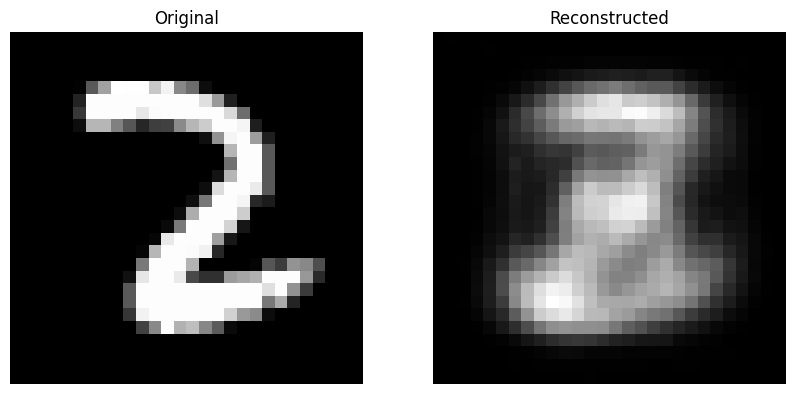

Epoch [1/10], Train Loss: 0.0660, Val Recon Loss: 0.0525, Val SSIM: 0.4283


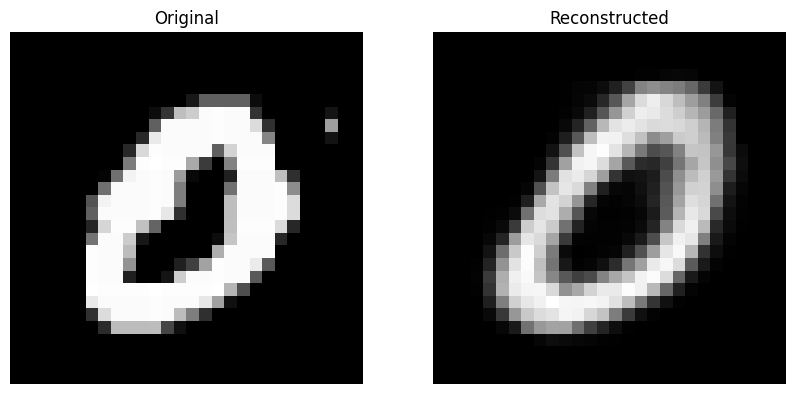

Epoch [2/10], Train Loss: 0.0458, Val Recon Loss: 0.0420, Val SSIM: 0.5573


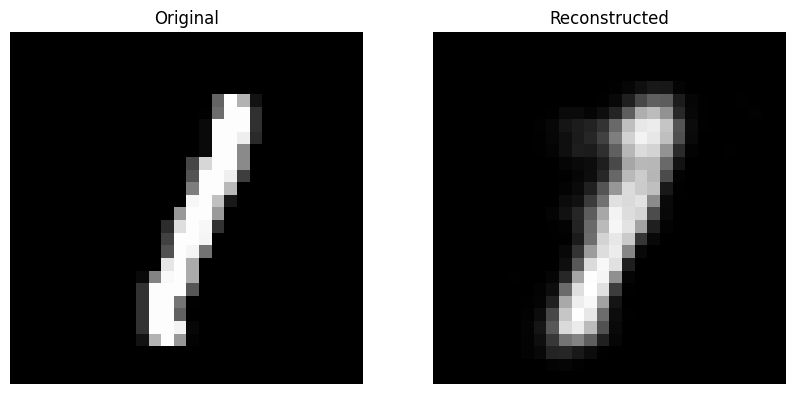

Epoch [3/10], Train Loss: 0.0400, Val Recon Loss: 0.0386, Val SSIM: 0.5988


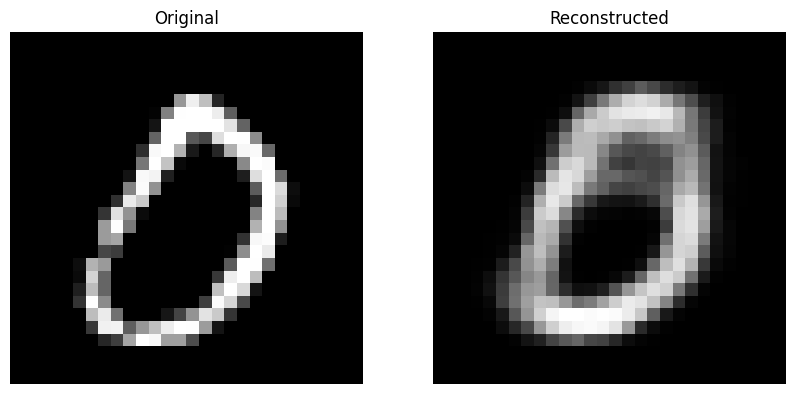

Epoch [4/10], Train Loss: 0.0374, Val Recon Loss: 0.0367, Val SSIM: 0.6266


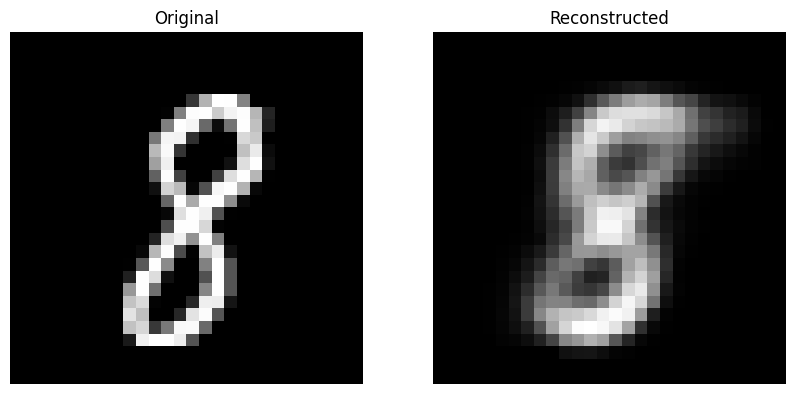

Epoch [5/10], Train Loss: 0.0359, Val Recon Loss: 0.0356, Val SSIM: 0.6393


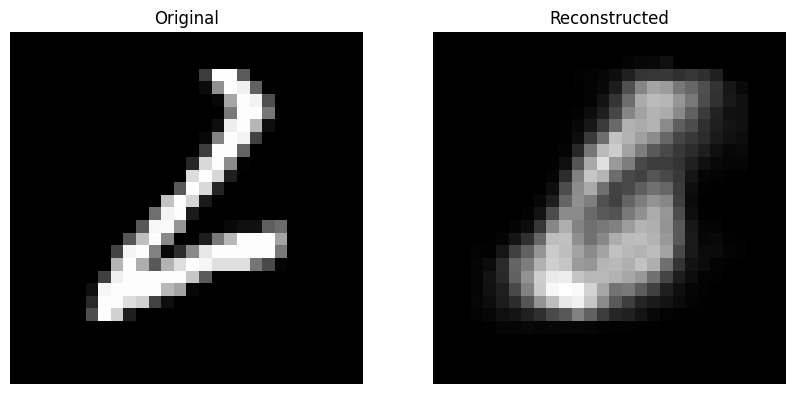

Epoch [6/10], Train Loss: 0.0348, Val Recon Loss: 0.0349, Val SSIM: 0.6465


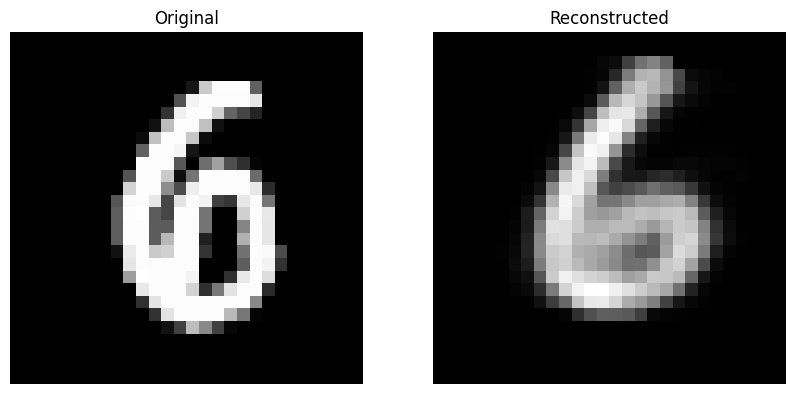

Epoch [7/10], Train Loss: 0.0338, Val Recon Loss: 0.0338, Val SSIM: 0.6565


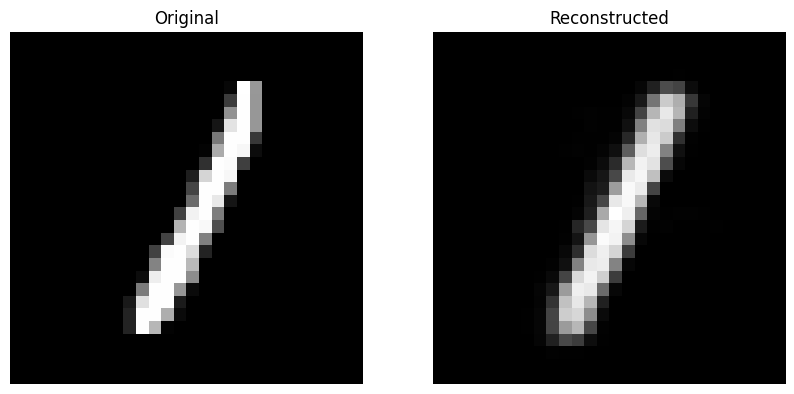

Epoch [8/10], Train Loss: 0.0326, Val Recon Loss: 0.0329, Val SSIM: 0.6668


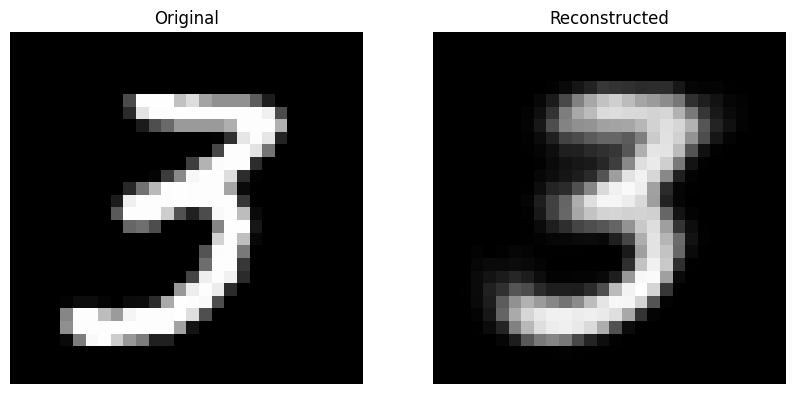

Epoch [9/10], Train Loss: 0.0315, Val Recon Loss: 0.0315, Val SSIM: 0.6785


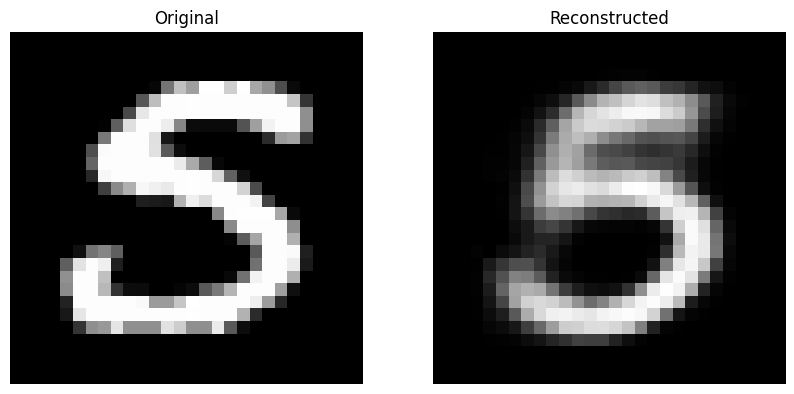

Epoch [10/10], Train Loss: 0.0305, Val Recon Loss: 0.0307, Val SSIM: 0.6871
Training finished.


In [11]:
train_model(model,10,train_loader,val_loader,optimizer,criterion,0,0)

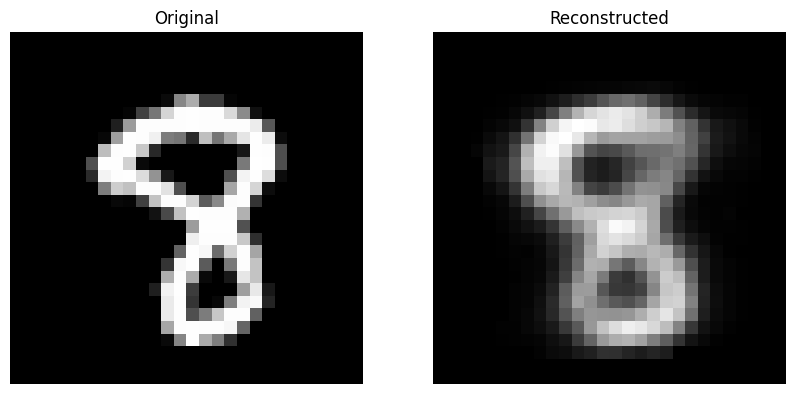

Final Reconstruction Loss: 0.0303, Final SSIM Score: 0.6927


In [16]:
final_loss, final_ssim_score = evaluate_model(model, test_loader, criterion)
print(f"Final Reconstruction Loss: {final_loss:.4f}, Final SSIM Score: {final_ssim_score:.4f}")


sigma 0.1


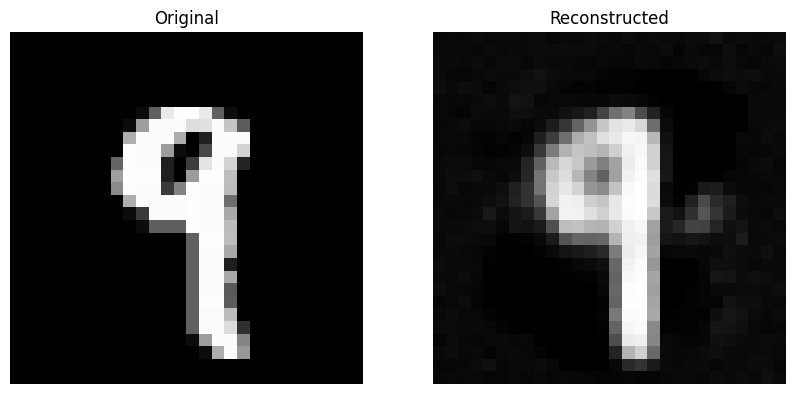

Epoch [1/10], Train Loss: 0.0285, Val Recon Loss: 0.0294, Val SSIM: 0.5788


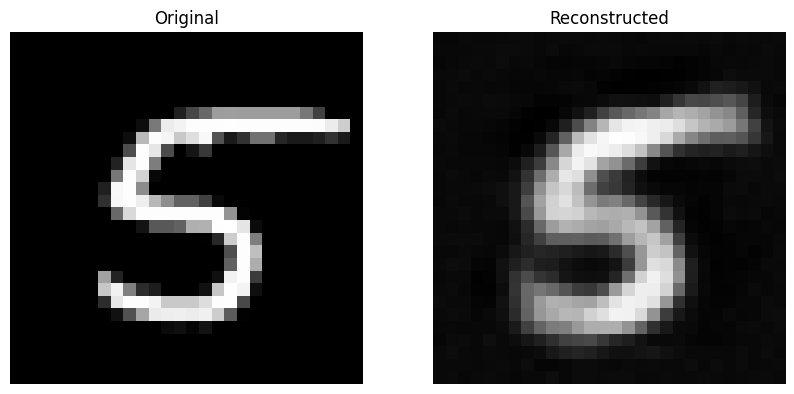

Epoch [2/10], Train Loss: 0.0279, Val Recon Loss: 0.0286, Val SSIM: 0.5814


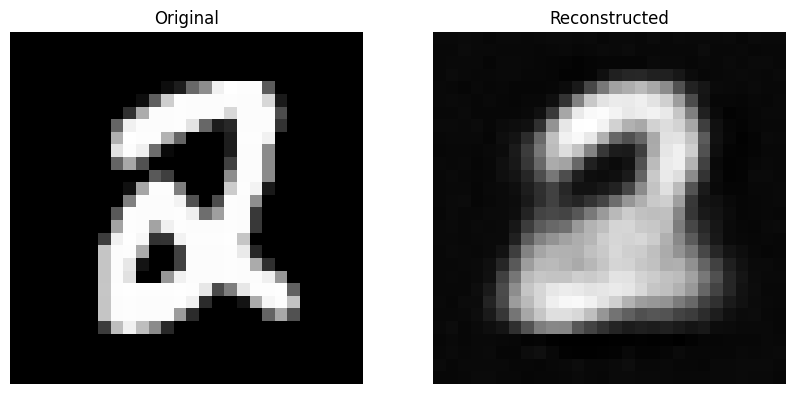

Epoch [3/10], Train Loss: 0.0273, Val Recon Loss: 0.0280, Val SSIM: 0.5857


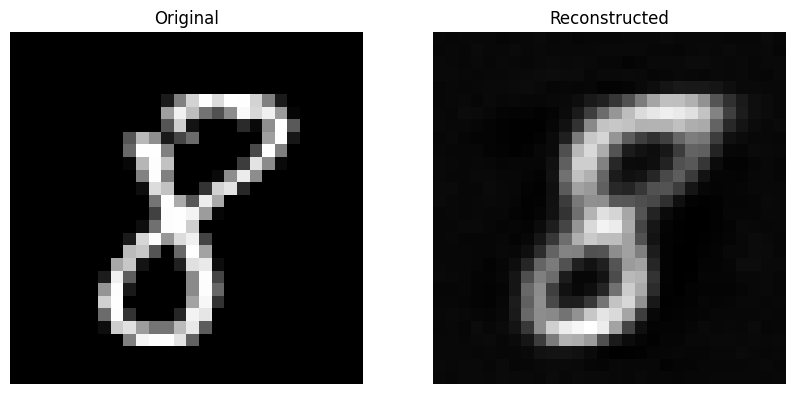

Epoch [4/10], Train Loss: 0.0269, Val Recon Loss: 0.0274, Val SSIM: 0.5895


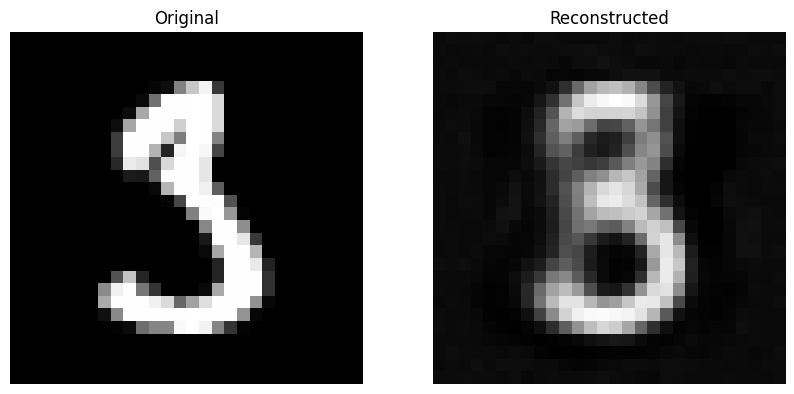

Epoch [5/10], Train Loss: 0.0265, Val Recon Loss: 0.0275, Val SSIM: 0.5803


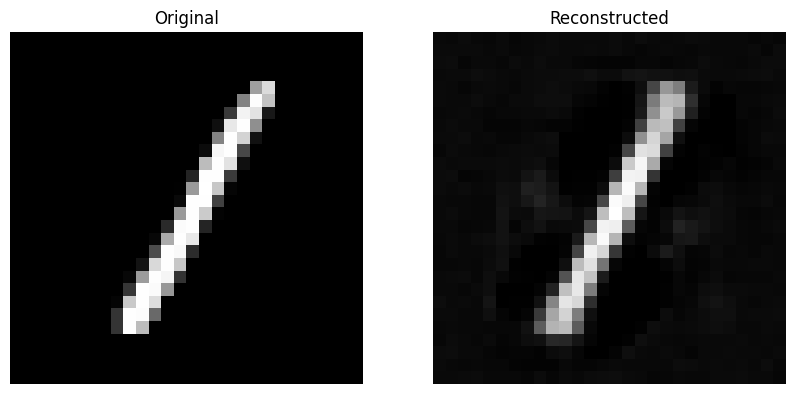

Epoch [6/10], Train Loss: 0.0263, Val Recon Loss: 0.0271, Val SSIM: 0.5844


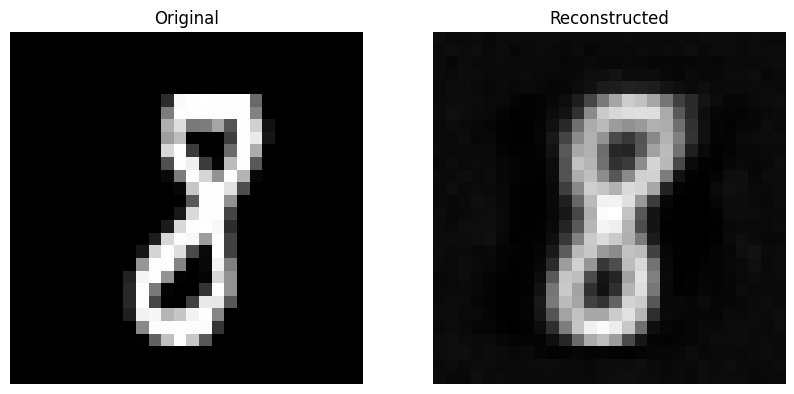

Epoch [7/10], Train Loss: 0.0260, Val Recon Loss: 0.0270, Val SSIM: 0.5837


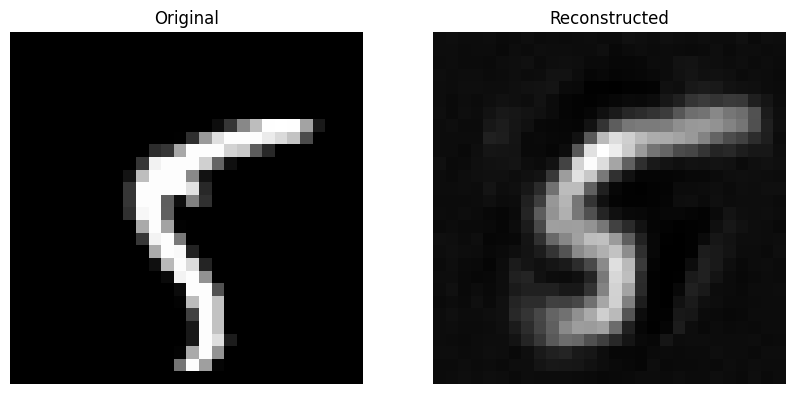

Epoch [8/10], Train Loss: 0.0257, Val Recon Loss: 0.0270, Val SSIM: 0.5816


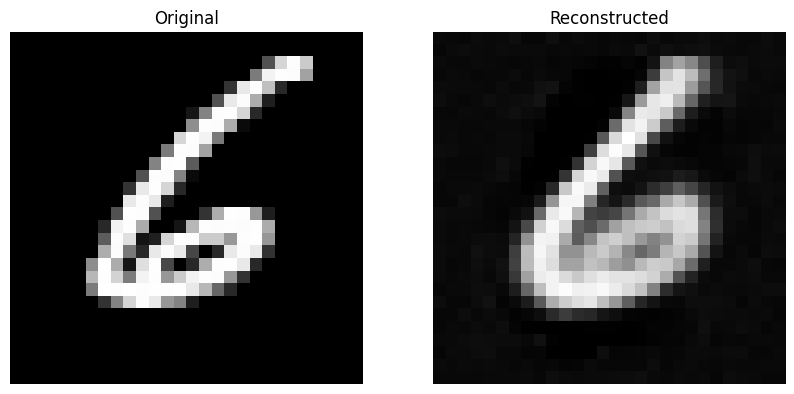

Epoch [9/10], Train Loss: 0.0255, Val Recon Loss: 0.0264, Val SSIM: 0.5915


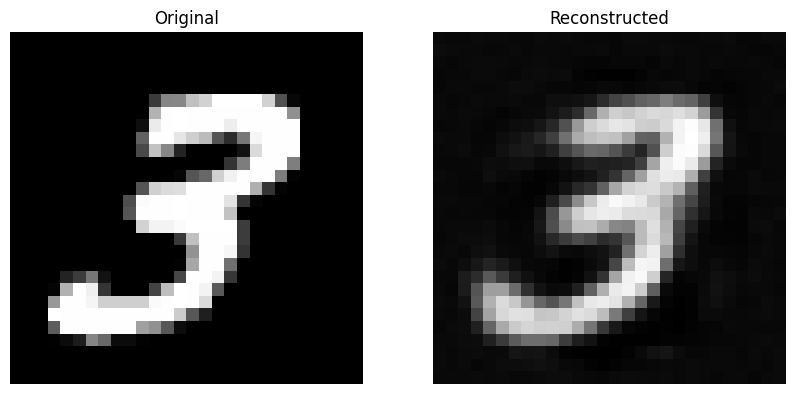

Epoch [10/10], Train Loss: 0.0253, Val Recon Loss: 0.0261, Val SSIM: 0.5954
Training finished.


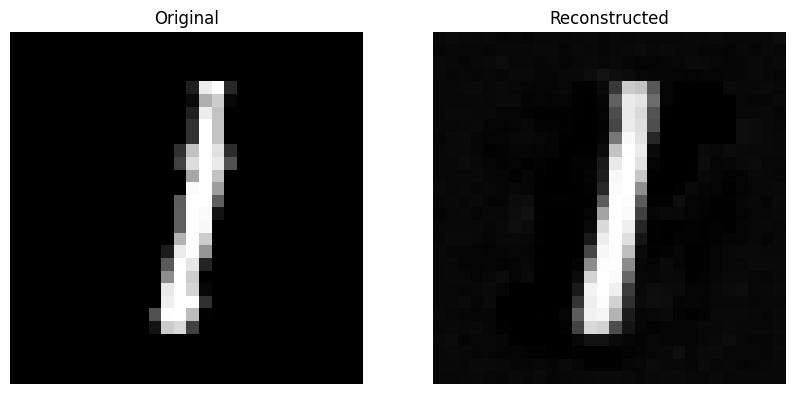

Sigma 0.1 completed, SSIM was 0.6006991296707013
sigma 10


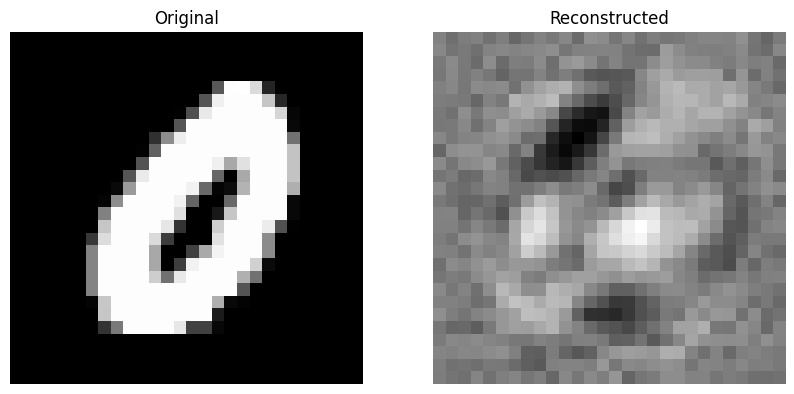

Epoch [1/10], Train Loss: 0.2434, Val Recon Loss: 0.1841, Val SSIM: 0.1003


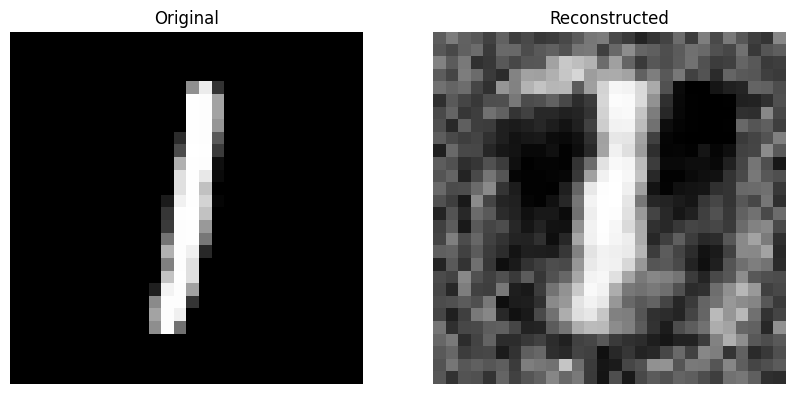

Epoch [2/10], Train Loss: 0.2420, Val Recon Loss: 0.1777, Val SSIM: 0.1046


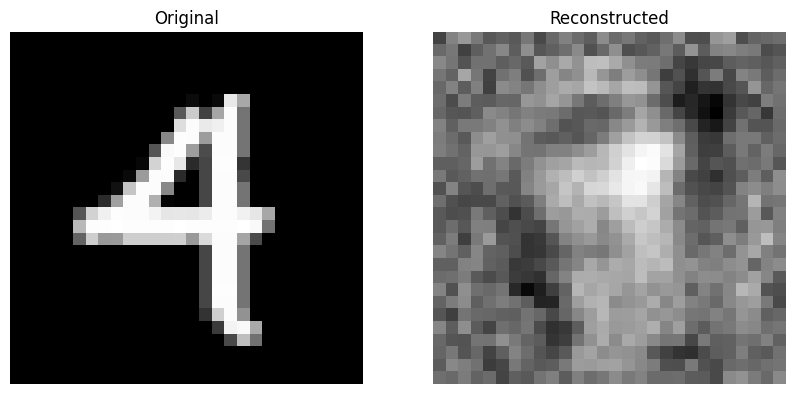

Epoch [3/10], Train Loss: 0.2419, Val Recon Loss: 0.1753, Val SSIM: 0.1067


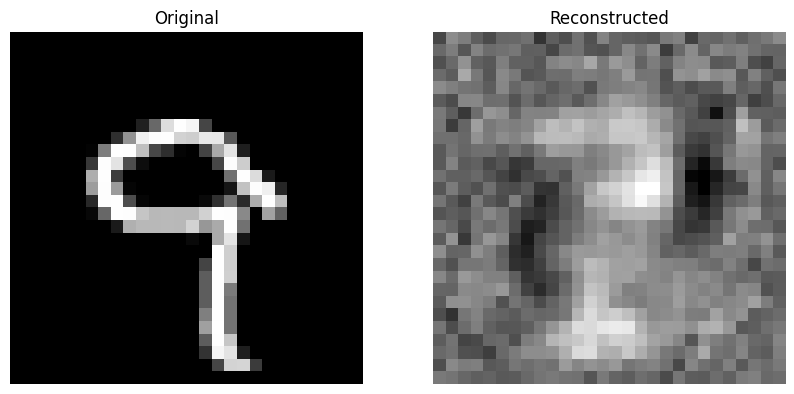

Epoch [4/10], Train Loss: 0.2419, Val Recon Loss: 0.1761, Val SSIM: 0.1076


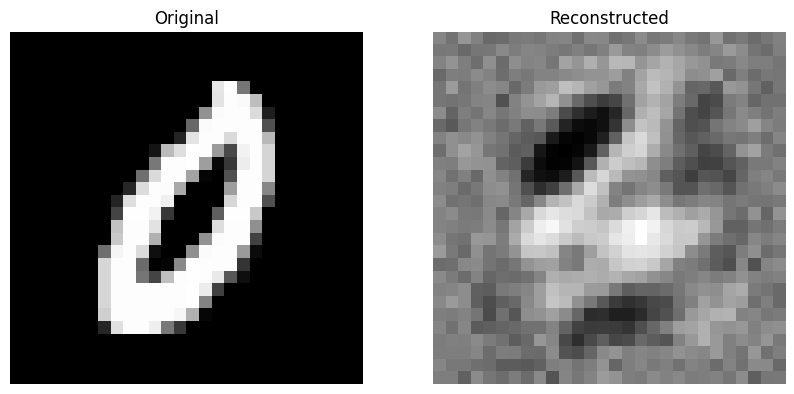

Epoch [5/10], Train Loss: 0.2419, Val Recon Loss: 0.1784, Val SSIM: 0.1066


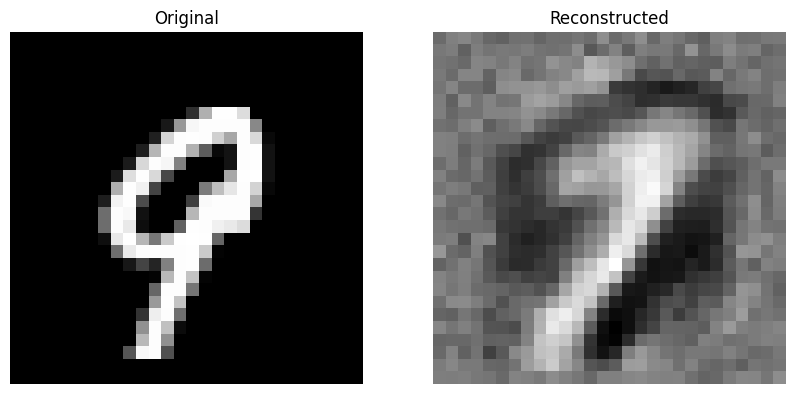

Epoch [6/10], Train Loss: 0.2419, Val Recon Loss: 0.1805, Val SSIM: 0.1060


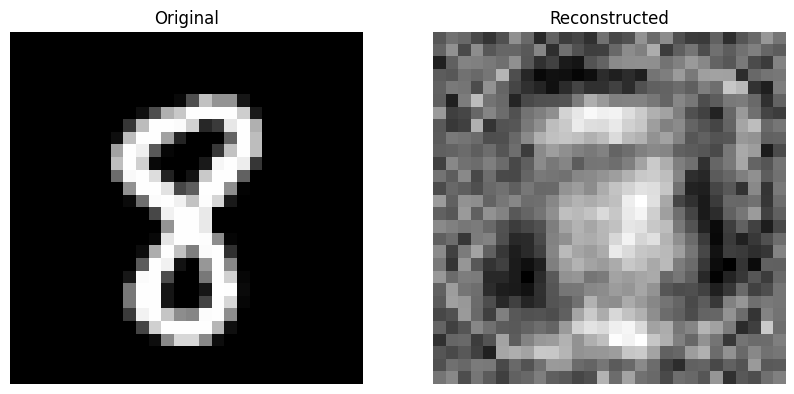

Epoch [7/10], Train Loss: 0.2419, Val Recon Loss: 0.1823, Val SSIM: 0.1061


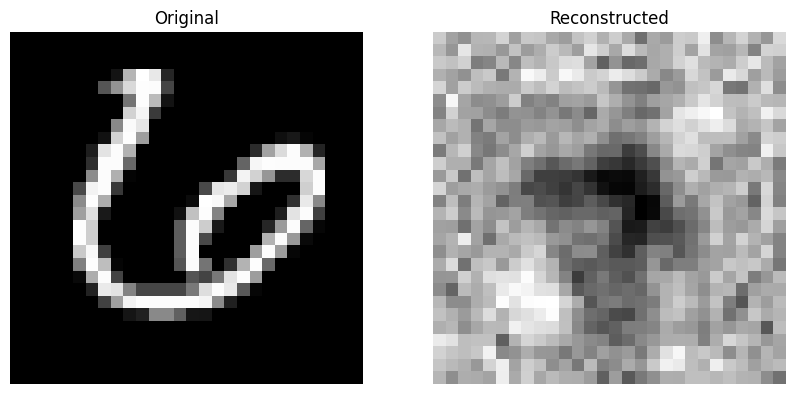

Epoch [8/10], Train Loss: 0.2419, Val Recon Loss: 0.1853, Val SSIM: 0.1044


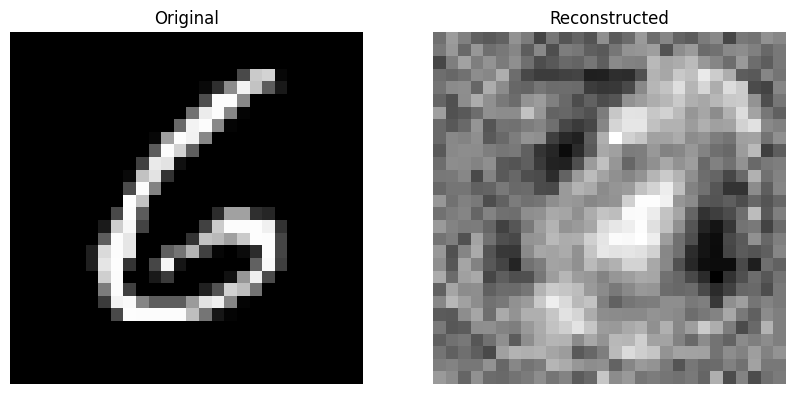

Epoch [9/10], Train Loss: 0.2419, Val Recon Loss: 0.1885, Val SSIM: 0.1017


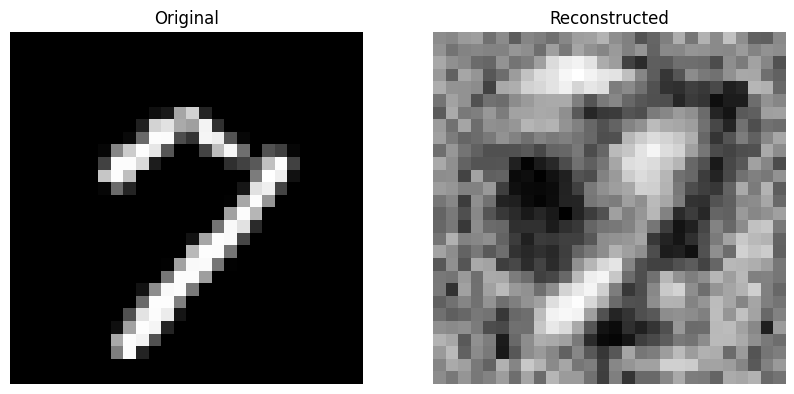

Epoch [10/10], Train Loss: 0.2419, Val Recon Loss: 0.1921, Val SSIM: 0.1011
Training finished.


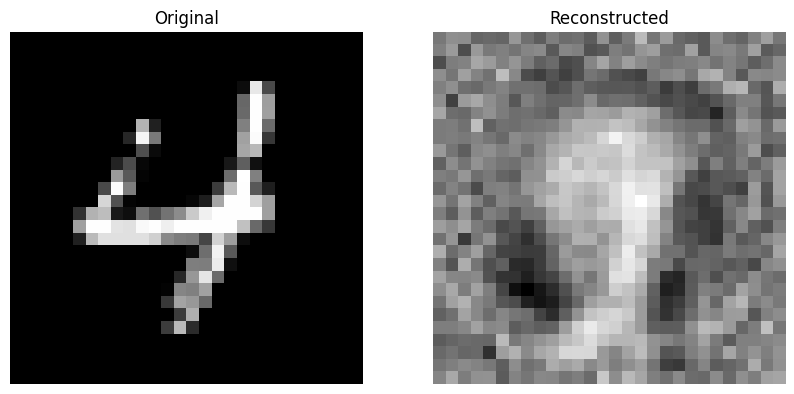

Sigma 10 completed, SSIM was 0.09783555919370014
sigma 60


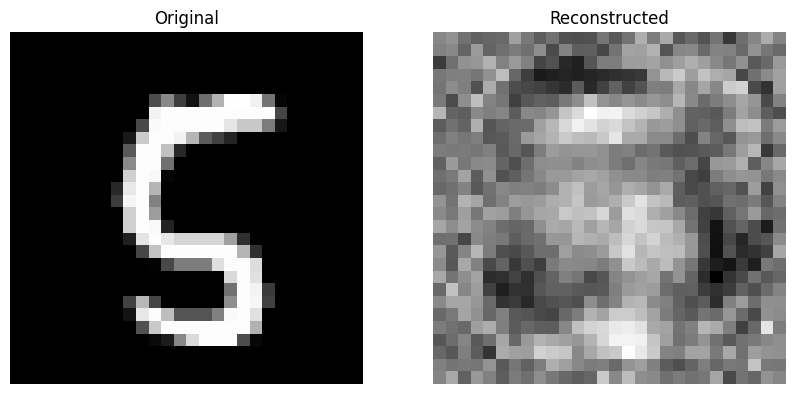

Epoch [1/10], Train Loss: 0.2477, Val Recon Loss: 0.1983, Val SSIM: 0.0985


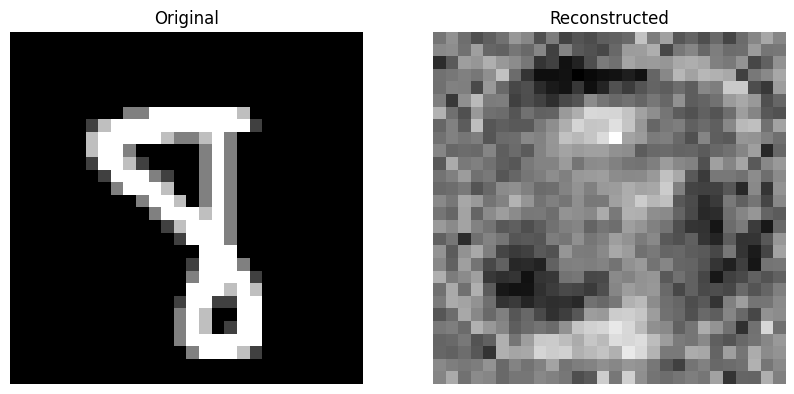

Epoch [2/10], Train Loss: 0.2477, Val Recon Loss: 0.2015, Val SSIM: 0.0969


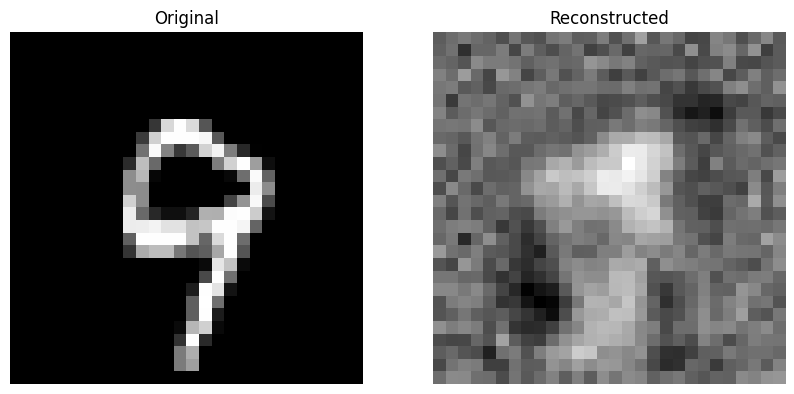

Epoch [3/10], Train Loss: 0.2477, Val Recon Loss: 0.2011, Val SSIM: 0.0965


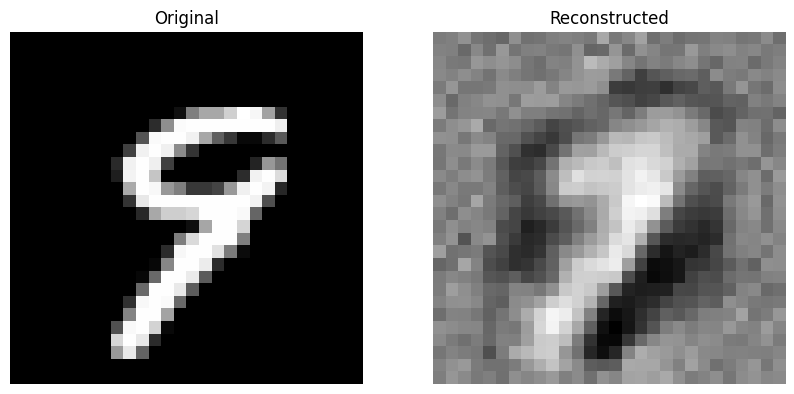

Epoch [4/10], Train Loss: 0.2477, Val Recon Loss: 0.2043, Val SSIM: 0.0949


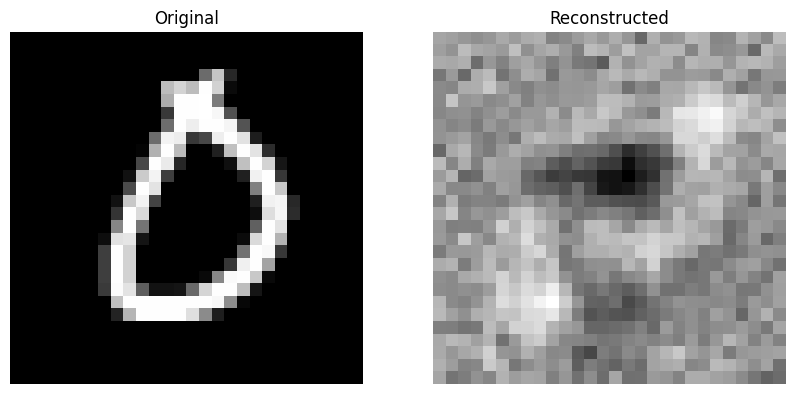

Epoch [5/10], Train Loss: 0.2477, Val Recon Loss: 0.2046, Val SSIM: 0.0951


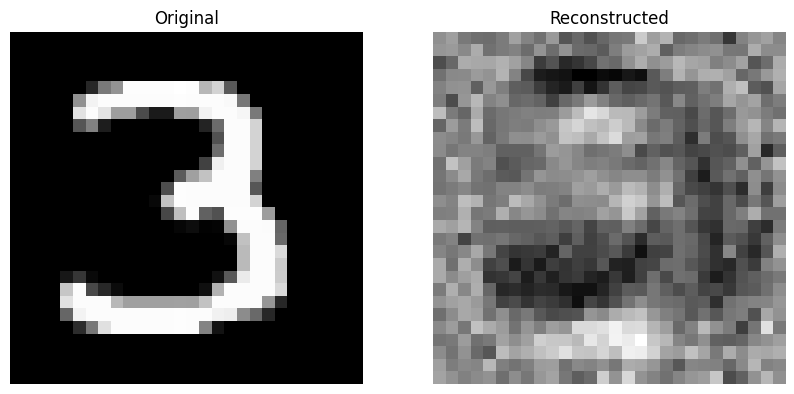

Epoch [6/10], Train Loss: 0.2476, Val Recon Loss: 0.2089, Val SSIM: 0.0926


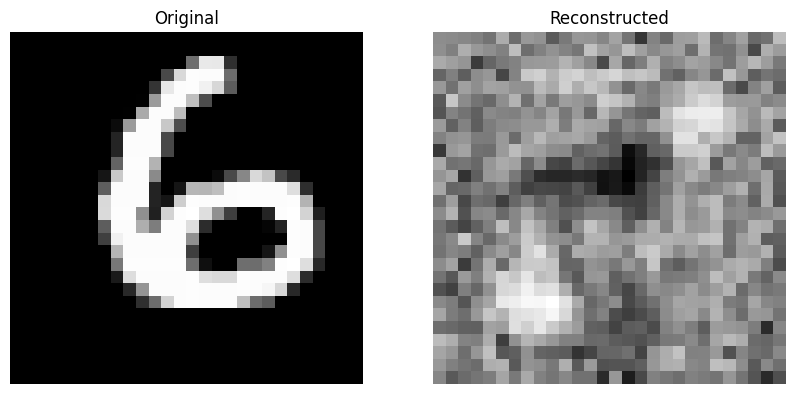

Epoch [7/10], Train Loss: 0.2474, Val Recon Loss: 0.2071, Val SSIM: 0.0915


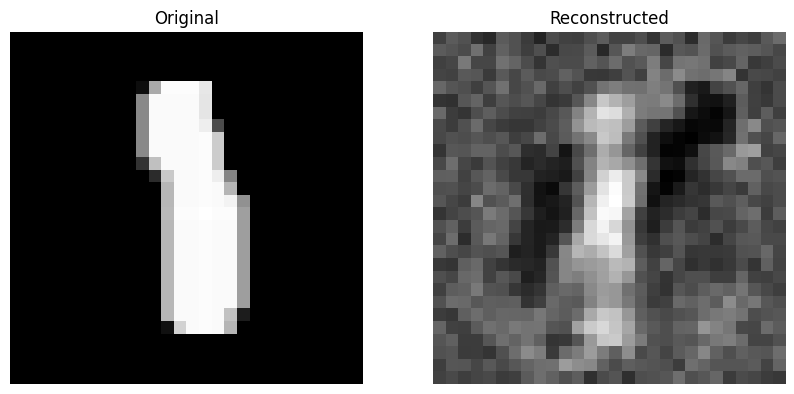

Epoch [8/10], Train Loss: 0.2473, Val Recon Loss: 0.2043, Val SSIM: 0.0901


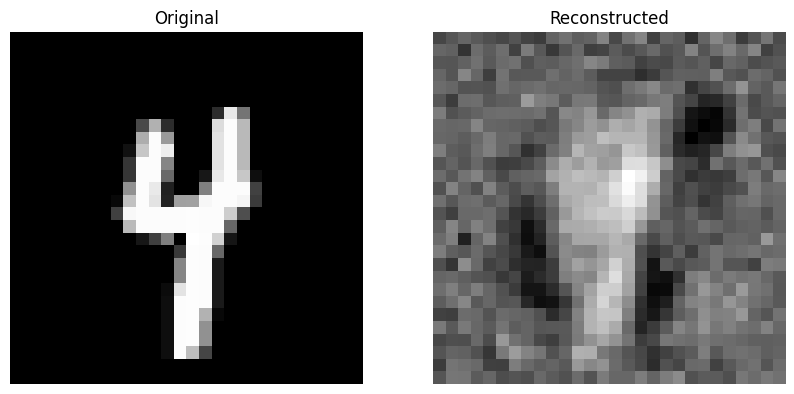

Epoch [9/10], Train Loss: 0.2474, Val Recon Loss: 0.2045, Val SSIM: 0.0905


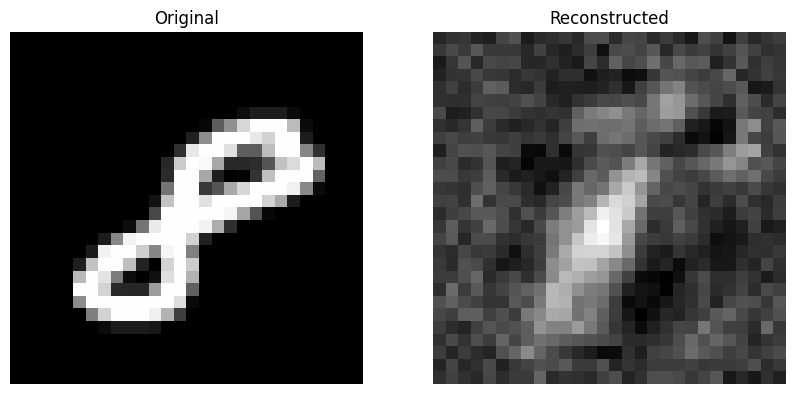

Epoch [10/10], Train Loss: 0.2473, Val Recon Loss: 0.2076, Val SSIM: 0.0879
Training finished.


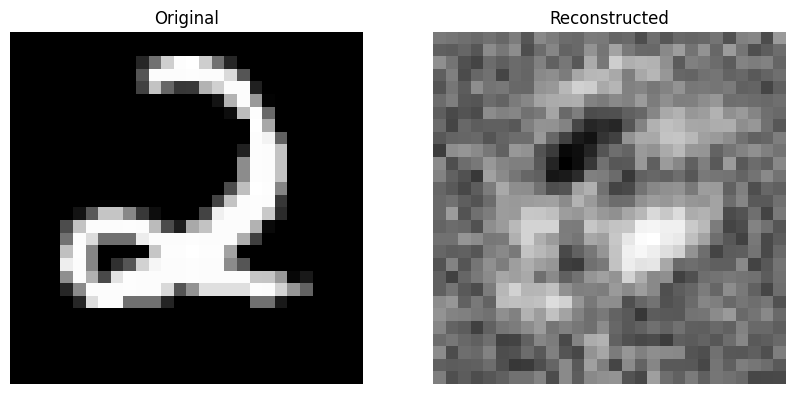

Sigma 60 completed, SSIM was 0.08366033701788957


In [19]:
# Define sigma values to test
sigma_values = [0.1, 10, 60]
avg_ssim_scores = []
avg_loss = []

# Train and evaluate the model for each sigma value
for sigma in sigma_values:
    print("sigma", sigma)
    train_model(model, 10, train_loader, val_loader, optimizer, criterion, sigma, 1)
    loss, avg_ssim = evaluate_model(model, test_loader, criterion)
    avg_ssim_scores.append(avg_ssim)
    avg_loss.append(loss)
    print("Sigma", sigma, "completed, SSIM was", avg_ssim)


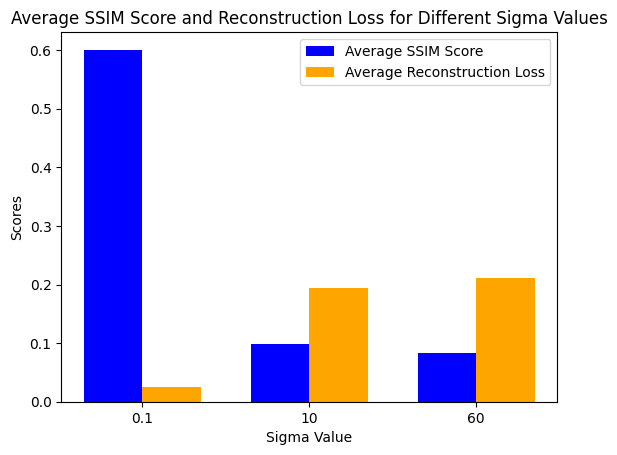

In [20]:
bar_width = 0.35
index = range(len(sigma_values))
fig, ax = plt.subplots()
bar1 = ax.bar(index, avg_ssim_scores, bar_width, label='Average SSIM Score', color='blue')
bar2 = ax.bar([i + bar_width for i in index], avg_loss, bar_width, label='Average Reconstruction Loss', color='orange')

# Add labels and title
ax.set_xlabel('Sigma Value')
ax.set_ylabel('Scores')
ax.set_title('Average SSIM Score and Reconstruction Loss for Different Sigma Values')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(sigma_values)
ax.legend()

# Show plot
plt.show()

In [21]:
import torch

class AutoEncoder2(torch.nn.Module):
    def __init__(self, bottleneck_size) -> None:
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, bottleneck_size),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28*28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


bottleneck : 1


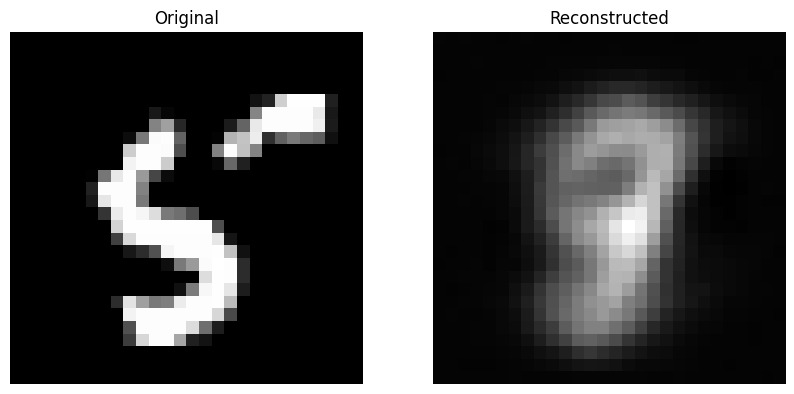

Epoch [1/10], Train Loss: 0.0638, Val Recon Loss: 0.0599, Val SSIM: 0.2999


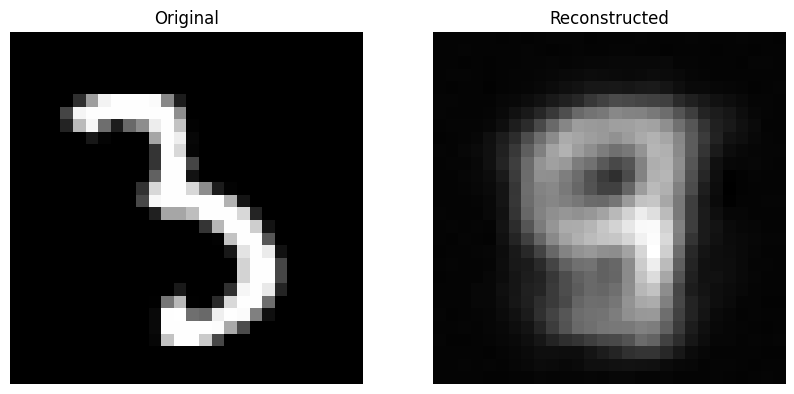

Epoch [2/10], Train Loss: 0.0539, Val Recon Loss: 0.0571, Val SSIM: 0.3252


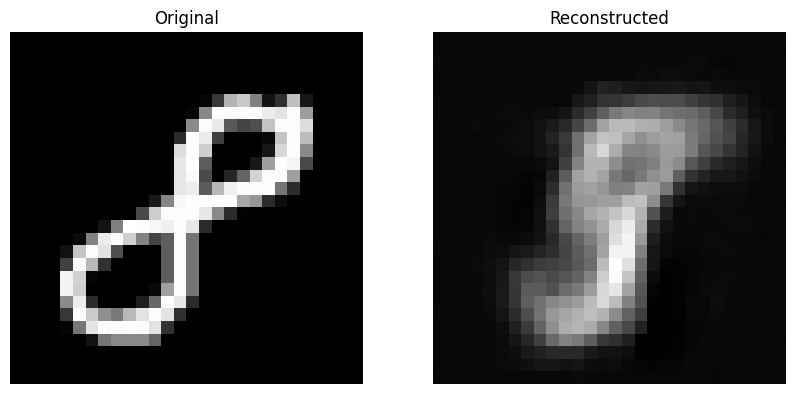

Epoch [3/10], Train Loss: 0.0514, Val Recon Loss: 0.0555, Val SSIM: 0.3493


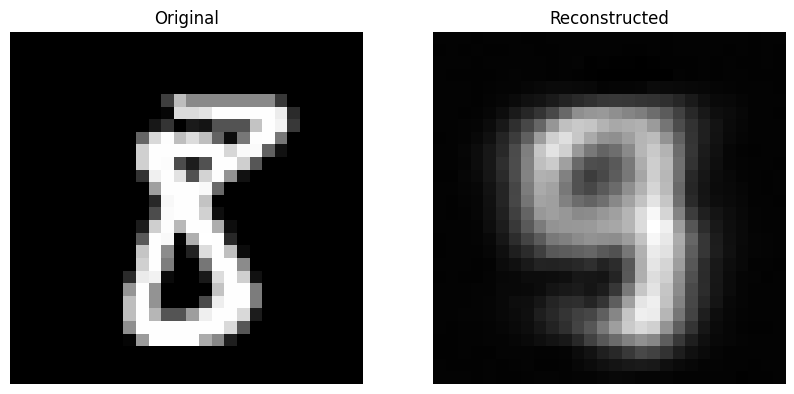

Epoch [4/10], Train Loss: 0.0498, Val Recon Loss: 0.0536, Val SSIM: 0.3693


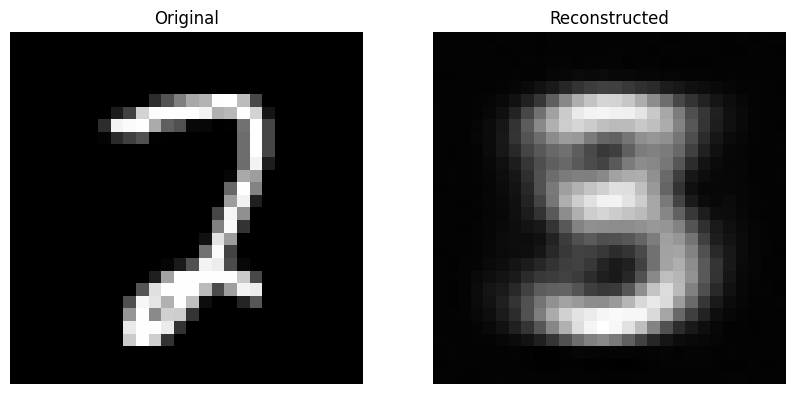

Epoch [5/10], Train Loss: 0.0484, Val Recon Loss: 0.0518, Val SSIM: 0.3795


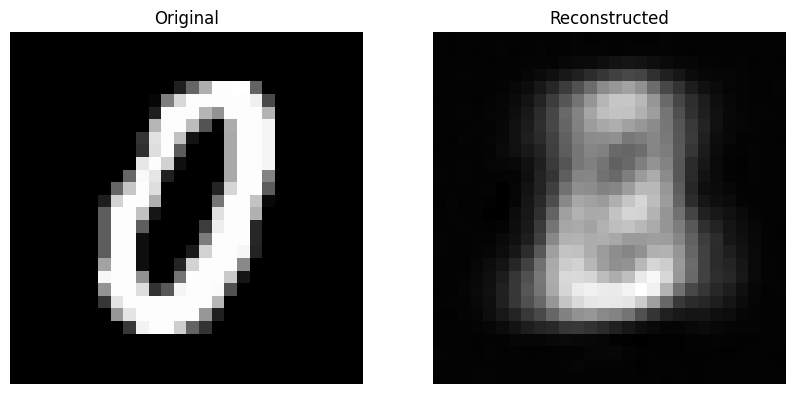

Epoch [6/10], Train Loss: 0.0472, Val Recon Loss: 0.0506, Val SSIM: 0.3902


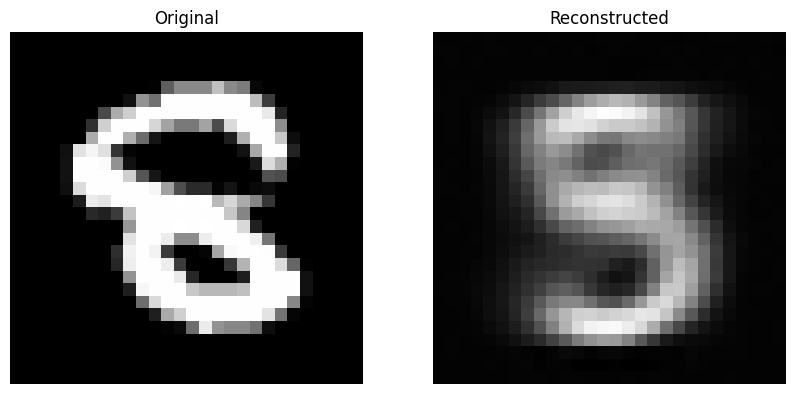

Epoch [7/10], Train Loss: 0.0465, Val Recon Loss: 0.0497, Val SSIM: 0.4016


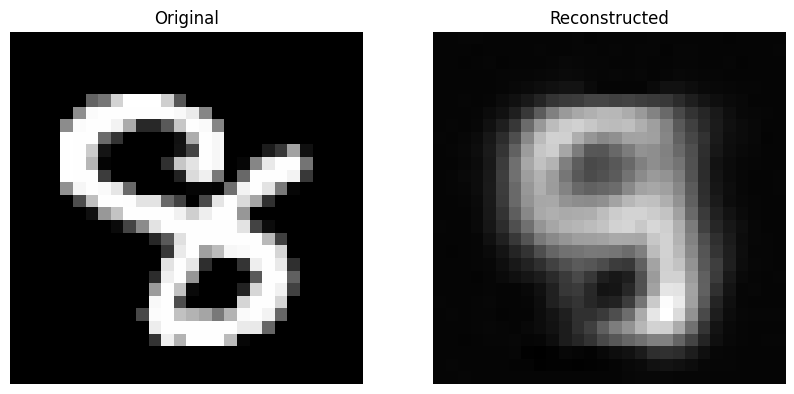

Epoch [8/10], Train Loss: 0.0462, Val Recon Loss: 0.0494, Val SSIM: 0.4078


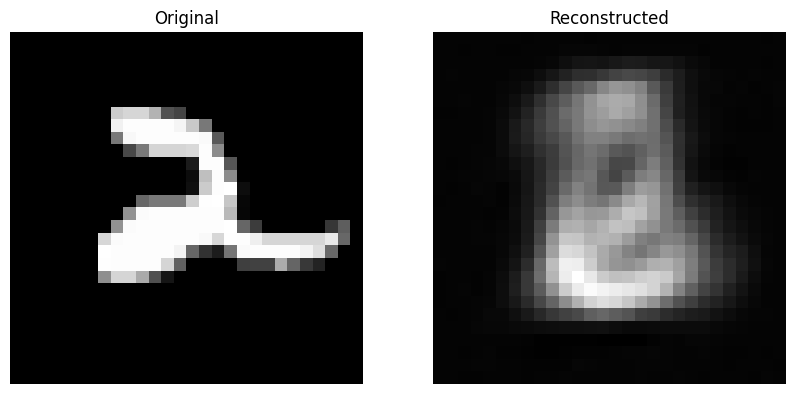

Epoch [9/10], Train Loss: 0.0457, Val Recon Loss: 0.0484, Val SSIM: 0.4227


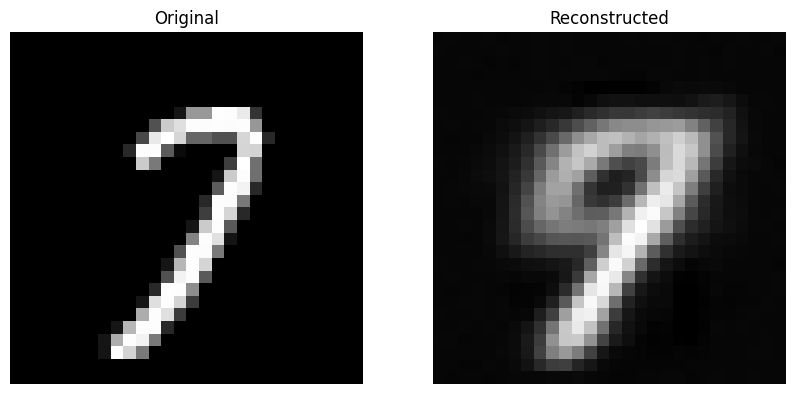

Epoch [10/10], Train Loss: 0.0456, Val Recon Loss: 0.0482, Val SSIM: 0.4109
Training finished.


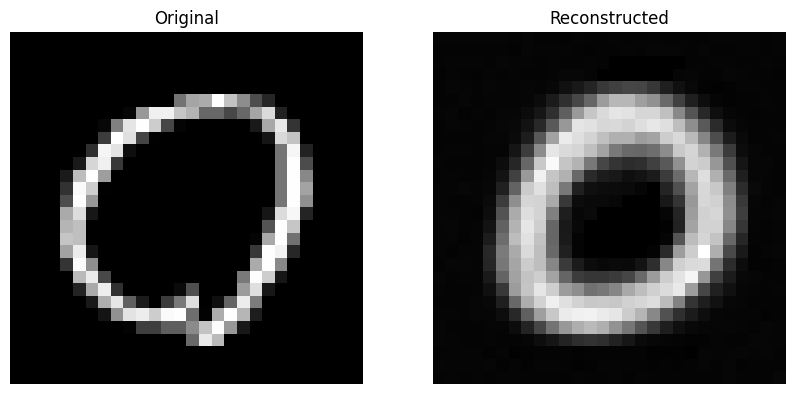

bottleneck : 3


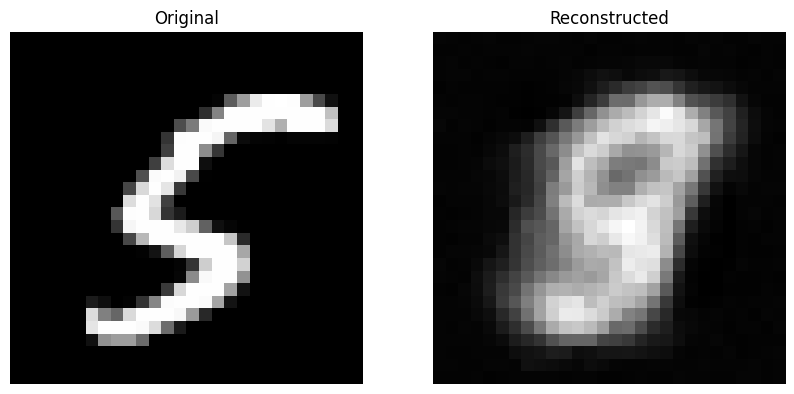

Epoch [1/10], Train Loss: 0.0608, Val Recon Loss: 0.0492, Val SSIM: 0.4312


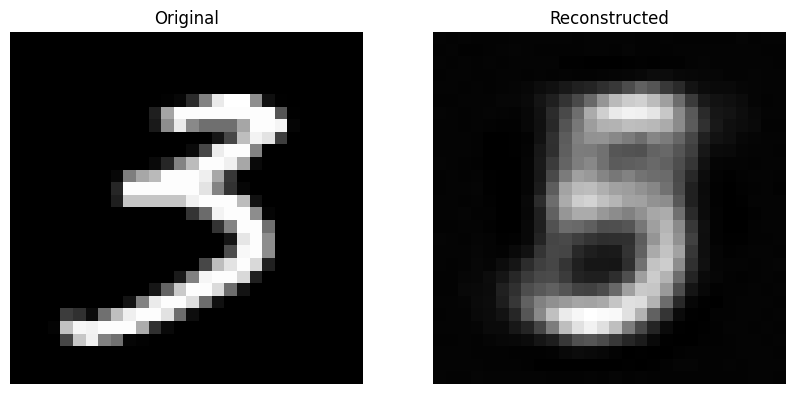

Epoch [2/10], Train Loss: 0.0414, Val Recon Loss: 0.0416, Val SSIM: 0.5192


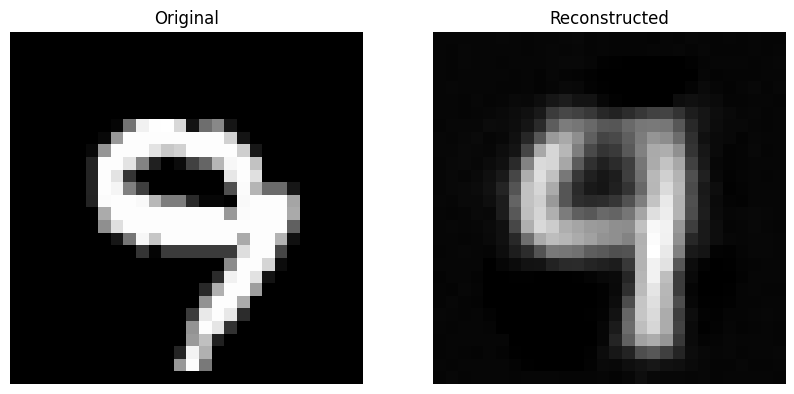

Epoch [3/10], Train Loss: 0.0372, Val Recon Loss: 0.0379, Val SSIM: 0.5565


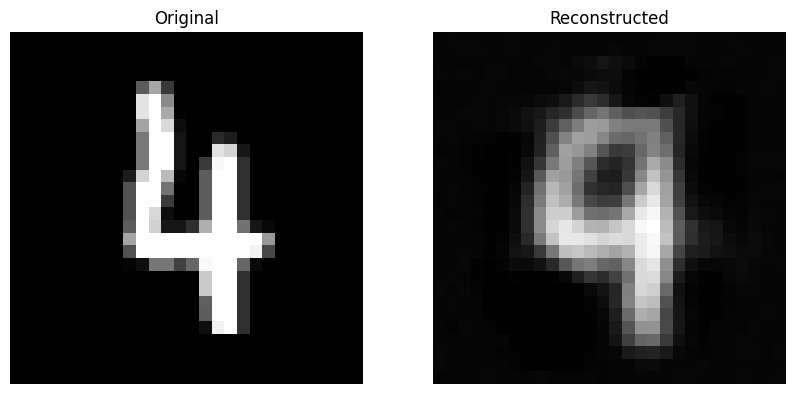

Epoch [4/10], Train Loss: 0.0352, Val Recon Loss: 0.0365, Val SSIM: 0.5737


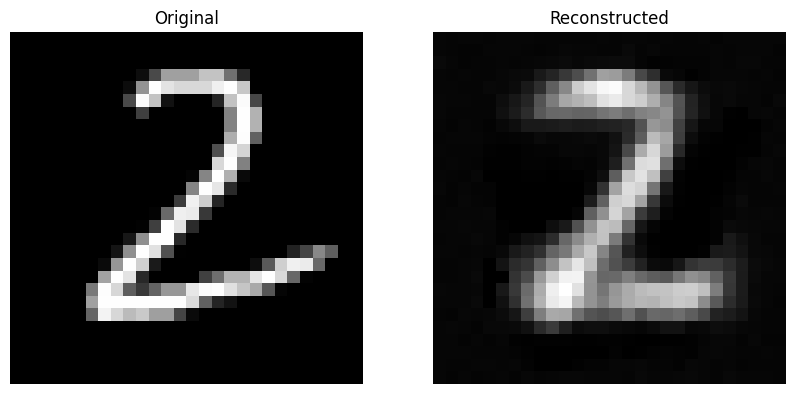

Epoch [5/10], Train Loss: 0.0341, Val Recon Loss: 0.0363, Val SSIM: 0.5733


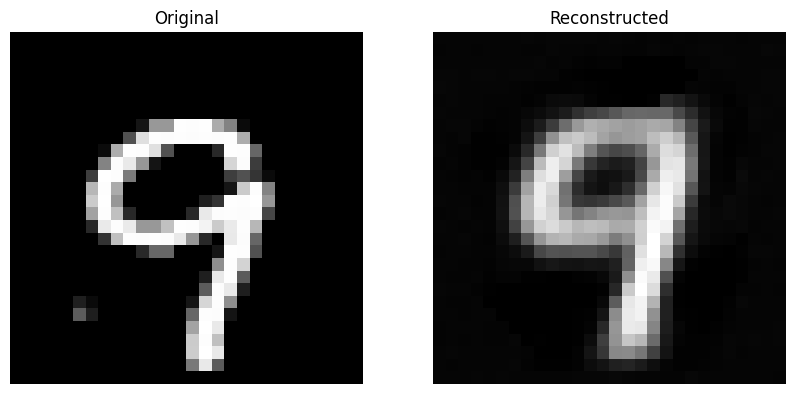

Epoch [6/10], Train Loss: 0.0332, Val Recon Loss: 0.0353, Val SSIM: 0.5898


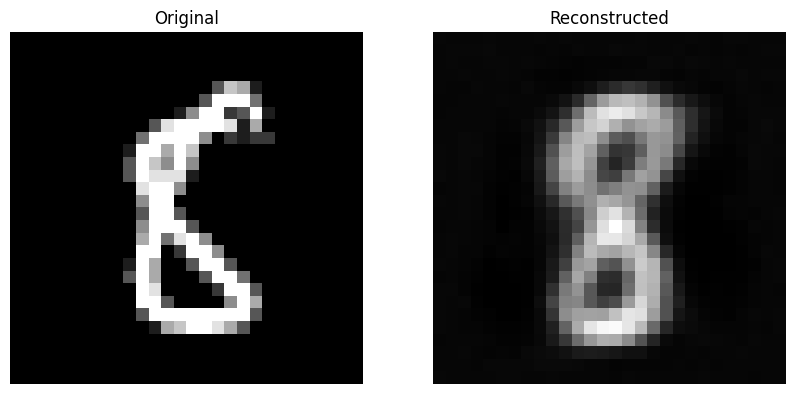

Epoch [7/10], Train Loss: 0.0325, Val Recon Loss: 0.0356, Val SSIM: 0.5812


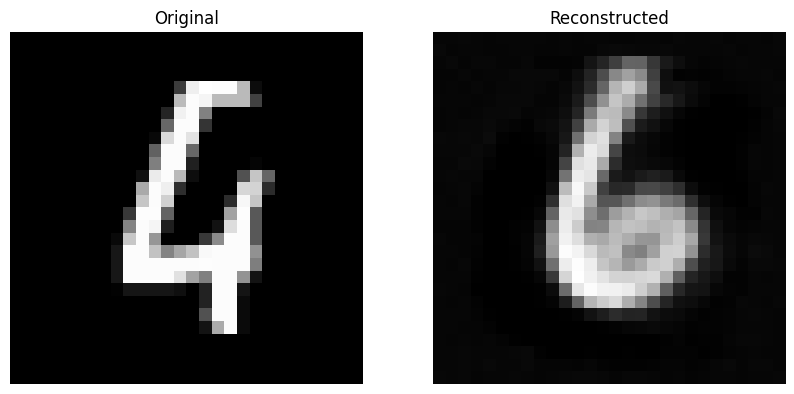

Epoch [8/10], Train Loss: 0.0321, Val Recon Loss: 0.0352, Val SSIM: 0.5854


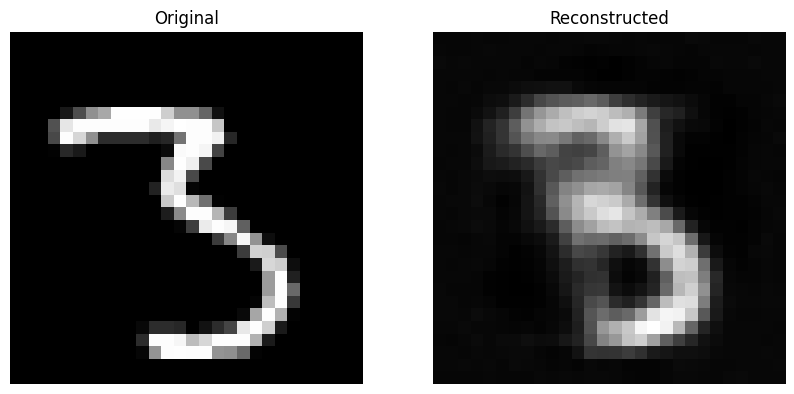

Epoch [9/10], Train Loss: 0.0317, Val Recon Loss: 0.0346, Val SSIM: 0.5879


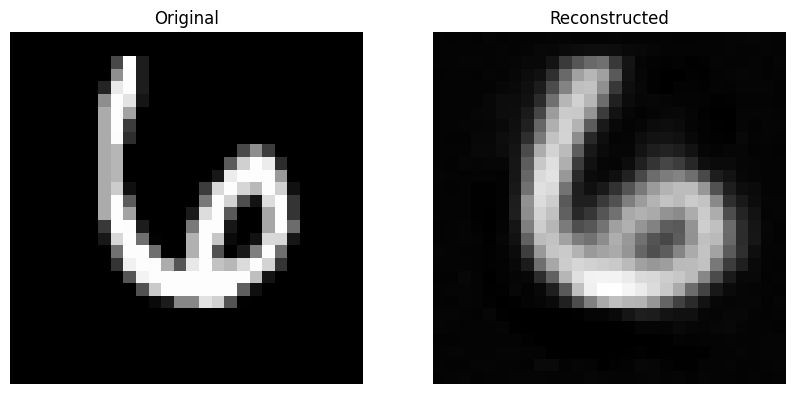

Epoch [10/10], Train Loss: 0.0312, Val Recon Loss: 0.0343, Val SSIM: 0.6001
Training finished.


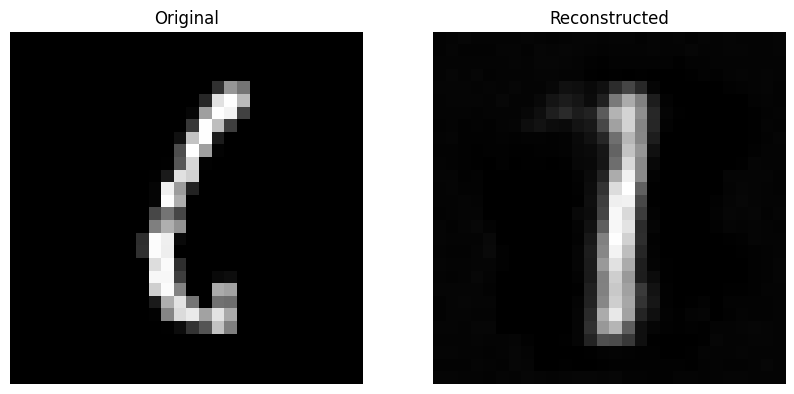

bottleneck : 9


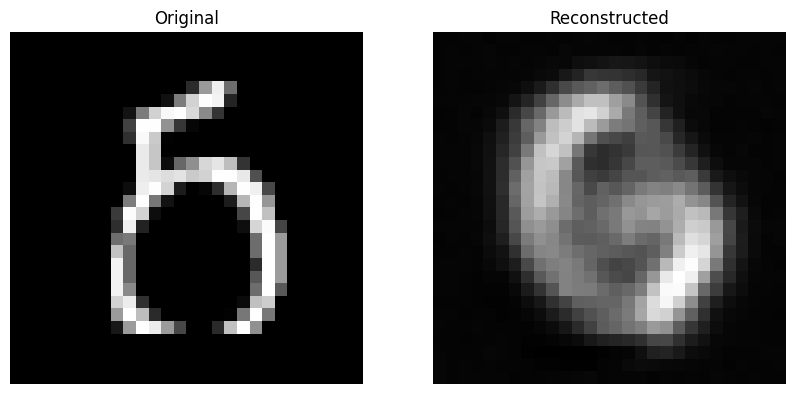

Epoch [1/10], Train Loss: 0.0589, Val Recon Loss: 0.0465, Val SSIM: 0.4562


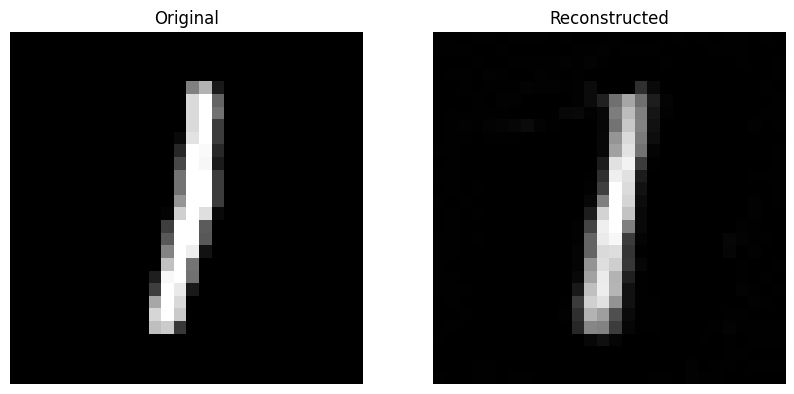

Epoch [2/10], Train Loss: 0.0377, Val Recon Loss: 0.0353, Val SSIM: 0.6176


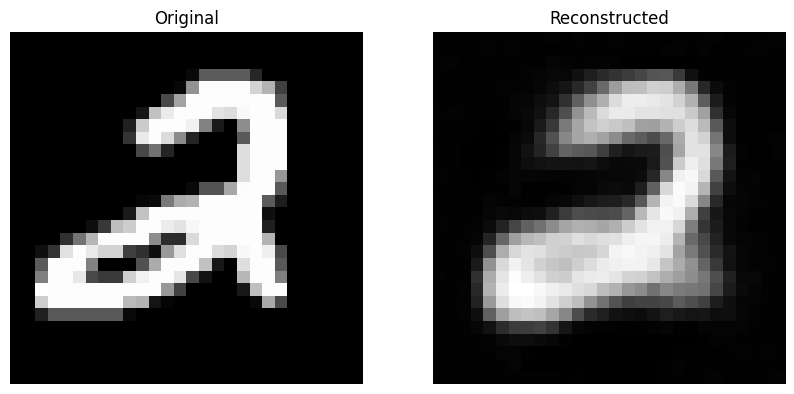

Epoch [3/10], Train Loss: 0.0304, Val Recon Loss: 0.0329, Val SSIM: 0.6368


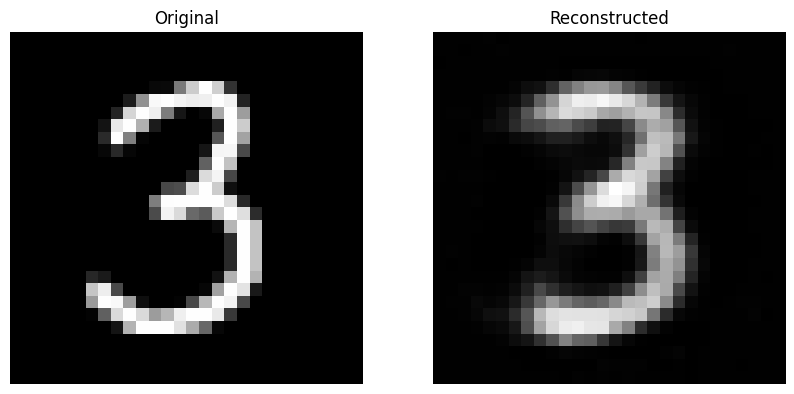

Epoch [4/10], Train Loss: 0.0280, Val Recon Loss: 0.0285, Val SSIM: 0.6881


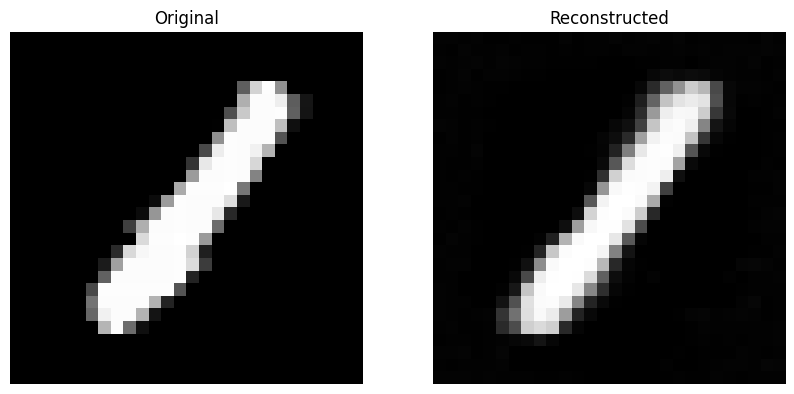

Epoch [5/10], Train Loss: 0.0260, Val Recon Loss: 0.0269, Val SSIM: 0.6946


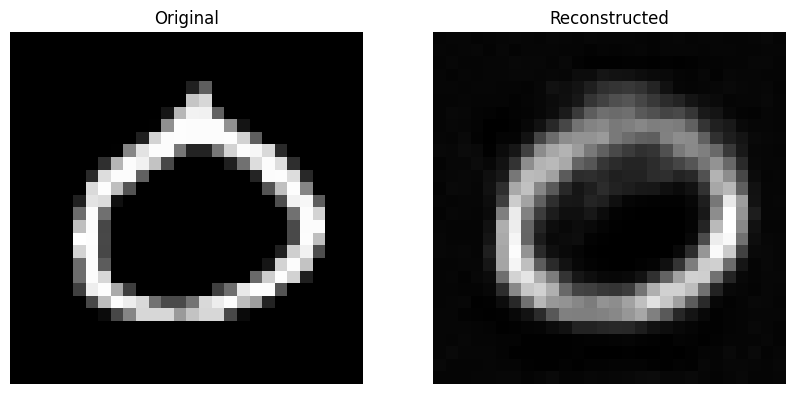

Epoch [6/10], Train Loss: 0.0248, Val Recon Loss: 0.0261, Val SSIM: 0.6954


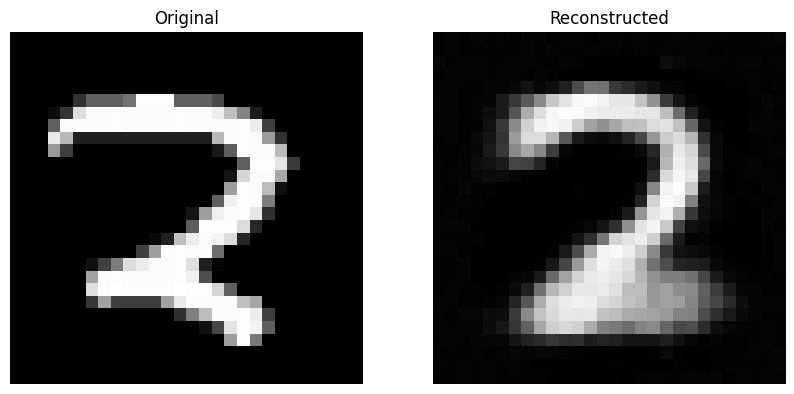

Epoch [7/10], Train Loss: 0.0240, Val Recon Loss: 0.0249, Val SSIM: 0.7007


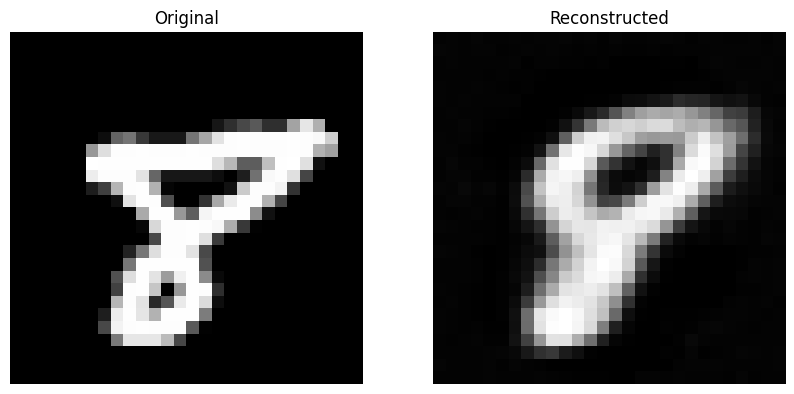

Epoch [8/10], Train Loss: 0.0233, Val Recon Loss: 0.0246, Val SSIM: 0.7120


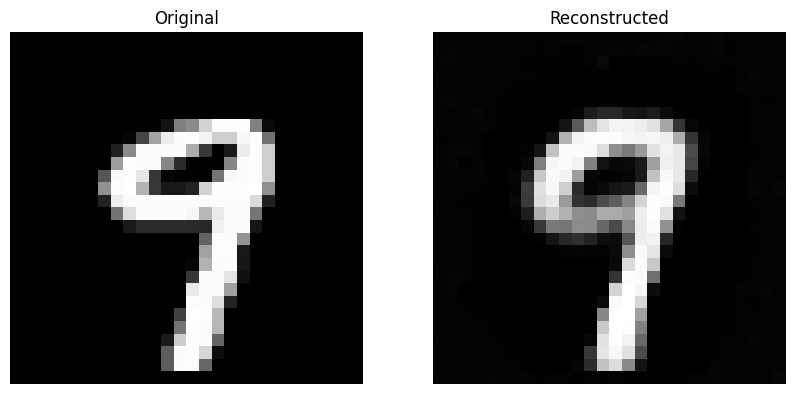

Epoch [9/10], Train Loss: 0.0228, Val Recon Loss: 0.0237, Val SSIM: 0.7182


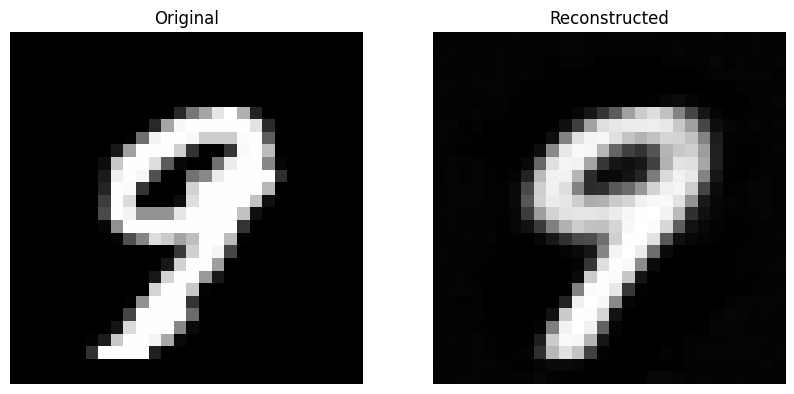

Epoch [10/10], Train Loss: 0.0223, Val Recon Loss: 0.0235, Val SSIM: 0.7122
Training finished.


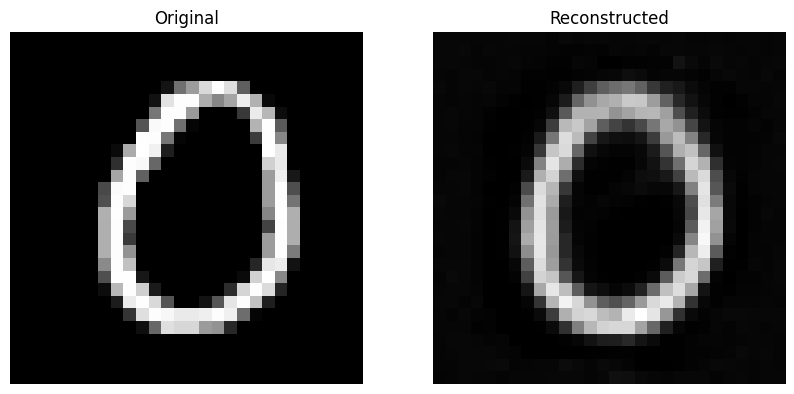

bottleneck : 16


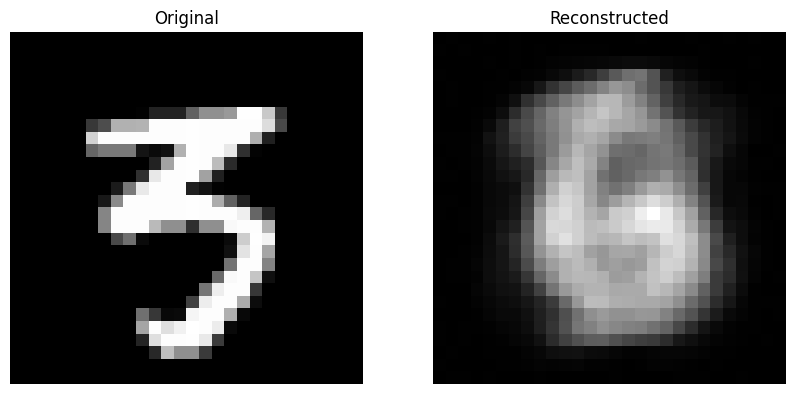

Epoch [1/10], Train Loss: 0.0606, Val Recon Loss: 0.0502, Val SSIM: 0.4301


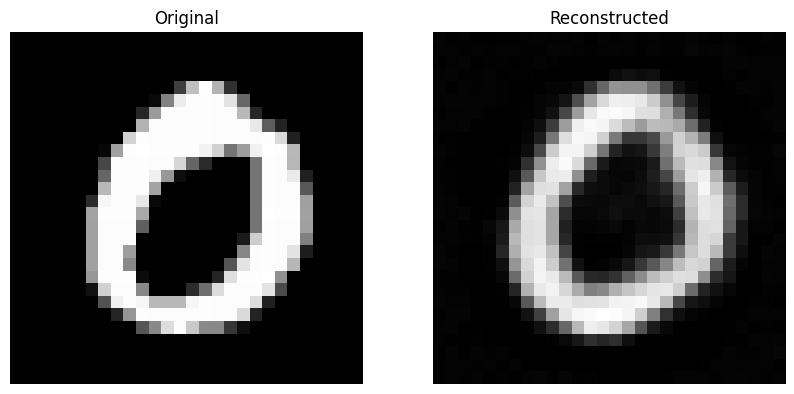

Epoch [2/10], Train Loss: 0.0396, Val Recon Loss: 0.0378, Val SSIM: 0.5773


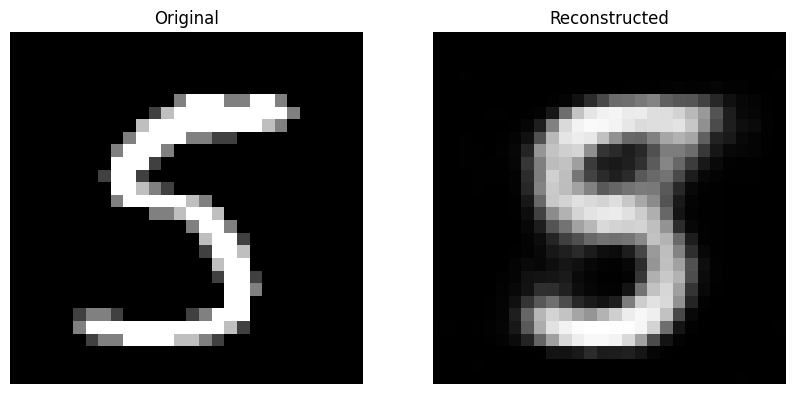

Epoch [3/10], Train Loss: 0.0322, Val Recon Loss: 0.0326, Val SSIM: 0.6321


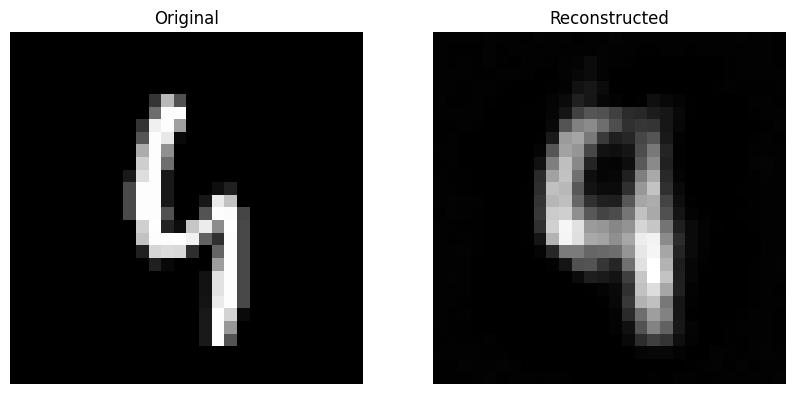

Epoch [4/10], Train Loss: 0.0294, Val Recon Loss: 0.0302, Val SSIM: 0.6545


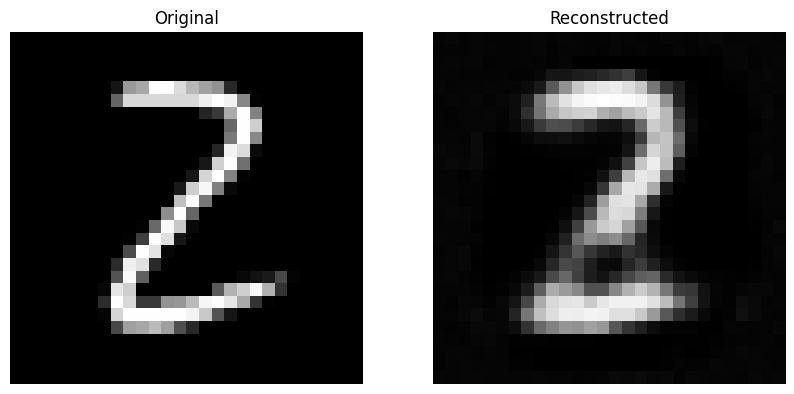

Epoch [5/10], Train Loss: 0.0264, Val Recon Loss: 0.0273, Val SSIM: 0.6839


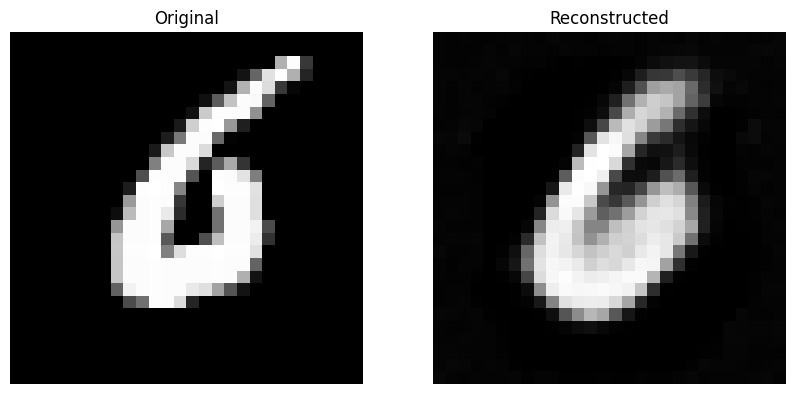

Epoch [6/10], Train Loss: 0.0247, Val Recon Loss: 0.0259, Val SSIM: 0.6975


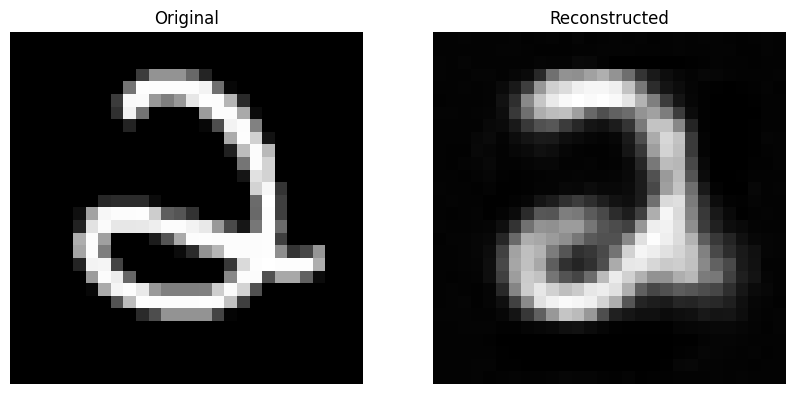

Epoch [7/10], Train Loss: 0.0234, Val Recon Loss: 0.0243, Val SSIM: 0.7257


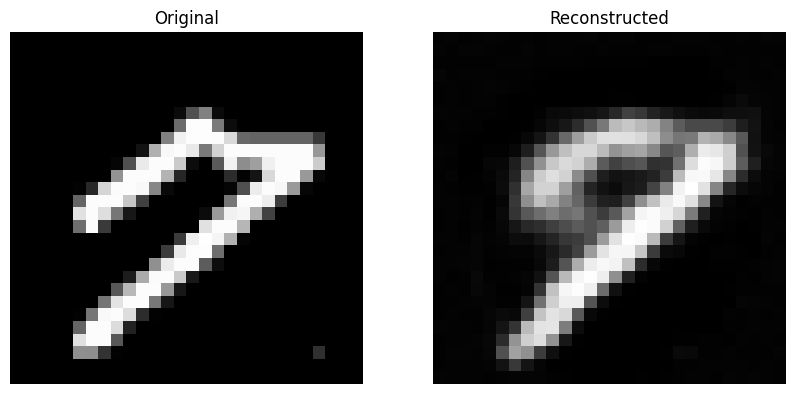

Epoch [8/10], Train Loss: 0.0224, Val Recon Loss: 0.0231, Val SSIM: 0.7366


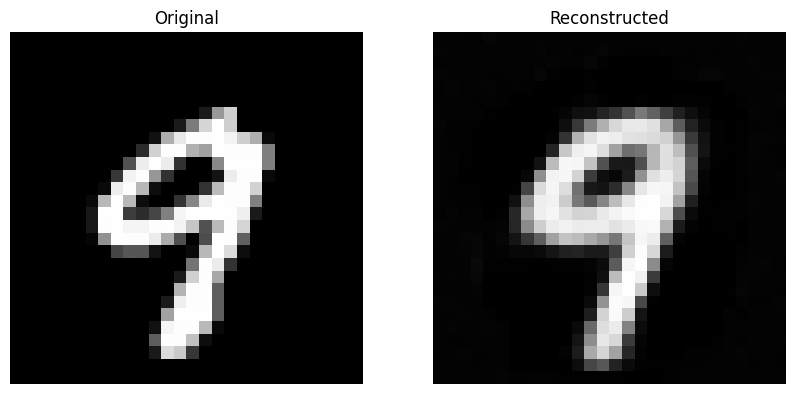

Epoch [9/10], Train Loss: 0.0215, Val Recon Loss: 0.0226, Val SSIM: 0.7440


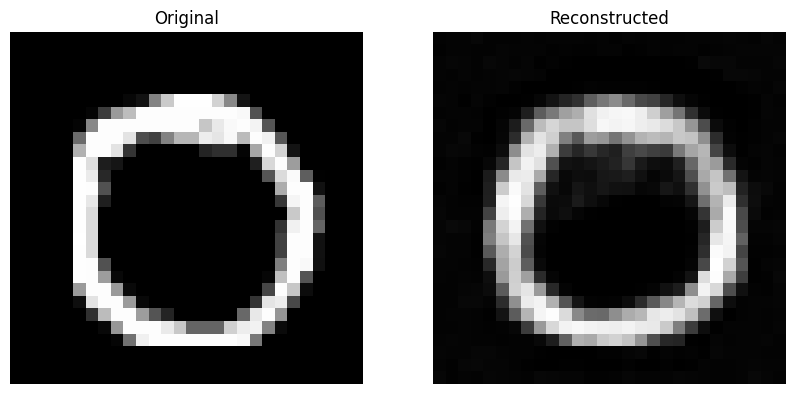

Epoch [10/10], Train Loss: 0.0209, Val Recon Loss: 0.0219, Val SSIM: 0.7478
Training finished.


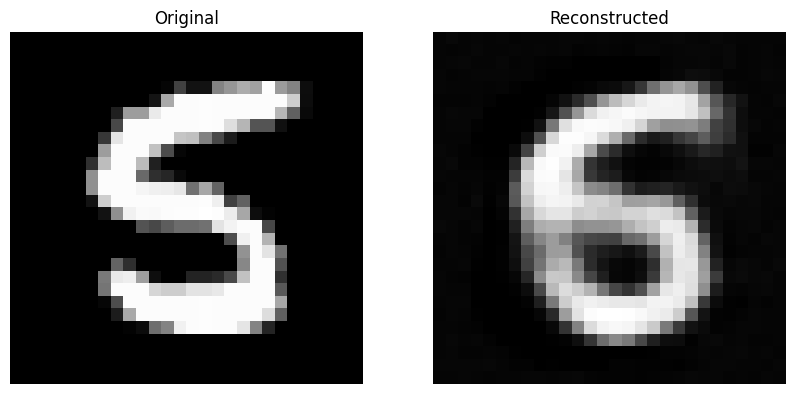

In [27]:
# Define sigma values to test
sigma= 0.05
avg_ssim_scores = []
avg_loss=[]
bottleneck_values = [1,3,9,16]
for bottleneck in bottleneck_values:
    print("bottleneck :",bottleneck)
    model2 = AutoEncoder2(bottleneck)
    model2 = model2.to(device)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
    train_model(model2, 10, train_loader,val_loader, optimizer2, criterion,sigma,1)
    loss,ssim_value = evaluate_model(model2, test_loader,criterion)
    avg_ssim_scores.append(ssim_value)
    avg_loss.append(loss)


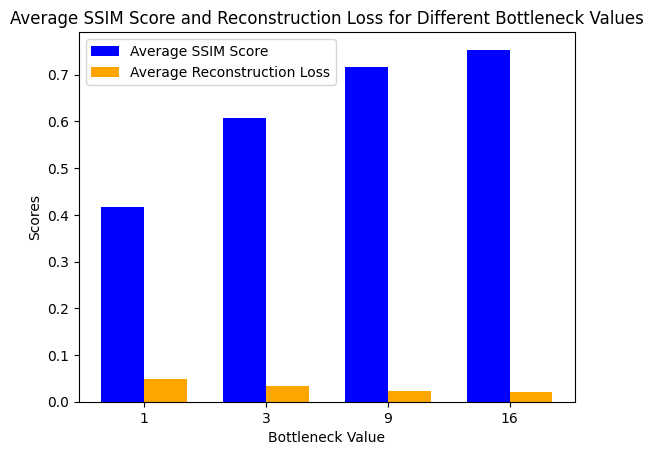

In [28]:
bar_width = 0.35
index = range(len(bottleneck_values))
fig, ax = plt.subplots()
bar1 = ax.bar(index, avg_ssim_scores, bar_width, label='Average SSIM Score', color='blue')
bar2 = ax.bar([i + bar_width for i in index], avg_loss, bar_width, label='Average Reconstruction Loss', color='orange')

# Add labels and title
ax.set_xlabel('Bottleneck Value')
ax.set_ylabel('Scores')
ax.set_title('Average SSIM Score and Reconstruction Loss for Different Bottleneck Values')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(bottleneck_values)
ax.legend()

# Show plot
plt.show()


FINAL OBSERVATIONS:
- Changing Bottleneck Values: As the bottleneck values increase, the SSIM increases. This is because increasing the bottleneck size results in less compression during encoding. With a larger bottleneck, more information is retained, leading to a better reconstruction of the input image and hence a higher SSIM.

- Adding Gaussian Noise During Training: When Gaussian noise is added during training, as the sigma (standard deviation) of the noise increases, the SSIM decreases. This is because training is being done on noisy data, which makes it more difficult for the autoencoder to reconstruct the original image accurately. As a result, the quality of the reconstruction decreases, leading to a lower SSIM score.